In [1]:
pip install autograd==1.7.0 autograd-gamma==0.5.0 interface_meta==1.3.0 formulaic==1.0.2 lifelines==0.30.0 pytorch-tabular scikit-learn torchmetrics einops

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn import metrics 


In [3]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.metrics import accuracy_score, f1_score  # or other metric functions

from pathlib import Path

import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')



pd.set_option('display.max_columns', 100)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

CATEGORICAL_VARIABLES = [
    # Graft and HCT reasons
    'dri_score', 'graft_type', 'prod_type', 'prim_disease_hct',

    # Patient health status (risk factors)
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_moderate',
    'pulm_severe', 'obesity', 'hepatic_mild', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue',
    'cardiac', 'prior_tumor', 'mrd_hct', 'tbi_status', 'cyto_score', 'cyto_score_detail', 

    # Patient demographics
    'ethnicity', 'race_group',
        # Biological matching with donor
    'sex_match', 'donor_related', 'cmv_status', 'tce_imm_match', 'tce_match', 'tce_div_match',

    # Medication/operation related data
    'melphalan_dose', 'rituximab', 'gvhd_proph', 'in_vivo_tcd', 'conditioning_intensity'
]
HLA_COLUMNS = [
    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',
    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    
    # Matching at HLA-A(low), -B(low), -DRB1(high)
    'hla_nmdp_6',
    # Matching at HLA-A,-B,-DRB1 (low or high)
    'hla_low_res_6', 'hla_high_res_6',
    # Matching at HLA-A, -B, -C, -DRB1 (low or high)
    'hla_low_res_8', 'hla_high_res_8',
    # Matching at HLA-A, -B, -C, -DRB1, -DQB1 (low or high)
    'hla_low_res_10', 'hla_high_res_10'
]

OTHER_NUMERICAL_VARIABLES = ['year_hct', 'donor_age', 'age_at_hct', 'comorbidity_score', 'karnofsky_score']
NUMERICAL_VARIABLES = HLA_COLUMNS + OTHER_NUMERICAL_VARIABLES

TARGET_VARIABLES = ['efs_time', 'efs']
ID_COLUMN = ["ID"]

def preprocess_data(df):
    df[CATEGORICAL_VARIABLES] = df[CATEGORICAL_VARIABLES].fillna("Unknown")
    df[OTHER_NUMERICAL_VARIABLES] = df[OTHER_NUMERICAL_VARIABLES].fillna(df[OTHER_NUMERICAL_VARIABLES].median())

    return df

train = preprocess_data(train)
test = preprocess_data(test)

def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] = df['year_hct'] - 2000
    
    return df
train = features_engineering(train)
test = features_engineering(test)

train[CATEGORICAL_VARIABLES] = train[CATEGORICAL_VARIABLES].astype('category')
test[CATEGORICAL_VARIABLES] = test[CATEGORICAL_VARIABLES].astype('category')

FEATURES = train.drop(columns=['ID', 'efs', 'efs_time']).columns.tolist()




In [6]:
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()
    model_xgb = XGBClassifier(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Using XGBoost version 2.1.4
#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65156
[100]	validation_0-auc:0.72704
[200]	validation_0-auc:0.73567
[300]	validation_0-auc:0.73992
[400]	validation_0-auc:0.74214
[500]	validation_0-auc:0.74334
[600]	validation_0-auc:0.74370
[625]	validation_0-auc:0.74376
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67182
[100]	validation_0-auc:0.75032
[200]	validation_0-auc:0.75882
[300]	validation_0-auc:0.76176
[400]	validation_0-auc:0.76379
[500]	validation_0-auc:0.76543
[583]	validation_0-auc:0.76604
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67016
[100]	validation_0-auc:0.74943
[200]	validation_0-auc:0.75823
[300]	validation_0-auc:0.76117
[400]	validation_0-auc:0.76222
[500]	validation_0-auc:0.76328
[587]	validation_0-auc:0.76335
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.66356
[100]	validatio

In [7]:
# Other lifelines things used

from lifelines import KaplanMeierFitter

# Cox model, linear with beta*X
from lifelines import CoxPHFitter

In [18]:

from lifelines.utils import concordance_index

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
  del solution[row_id_column_name]
  del submission[row_id_column_name]
  event_label = 'efs'
  interval_label = 'efs_time'
  prediction_label = 'prediction' 
  merged_df = pd.concat([solution, submission], axis=1)
  merged_df.reset_index(inplace=True)
  merged_df_race_dict = dict(merged_df.groupby(['race_group'],observed=False).groups)
  metric_list = []
  for race in merged_df_race_dict.keys():
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
        return float(np.mean(metric_list)-np.sqrt(np.var(metric_list))), np.array(metric_list)
      

In [19]:
def print_score(yrisk, output=False):
    # Calculate the C-score for the yrisk values for the train data.
    # Assumes risk_true and risk_pred dataframes are set up in the environment, e.g., using:
    #   risk_true = train[["ID","efs","efs_time","race_group"]].copy()
    #   risk_pred = train[["ID"]].copy()
    risk_pred["prediction"] = yrisk
    cscore, carray = score(risk_true.copy(), risk_pred.copy(), "ID")
    print("C Score = {:.4f} (std={:.4f}, total={:.4f}) from: ".format(
                cscore, np.sqrt(np.var(carray)), cscore + np.sqrt(np.var(carray))),
                  np.round(carray,4))
    if output: return cscore, carray

In [20]:
def survivals_from_data(times, deltas):
    # Kaplan Meier method implemented by hand for comprehension  :)
    tstep = 0.25 # time units
    tvals = np.arange(0.0,160.0,tstep)
    atrisk = 0.0*tvals; atrisk[0] = len(times)
    s_event = 0.0*tvals; s_event[0] = 1.0
    s_censor = 0.0*tvals; s_censor[0] = 1.0
    for istep, tval in enumerate(tvals[0:-1]):
        ##print("{:3} {:7.2f} {:7.0f} {:10.6f} {:10.6f}".format(istep, tval,
        ##                        atrisk[istep], s_event[istep], s_censor[istep]))
        n_events = sum( (times >= tval) & (times < tvals[istep+1]) & (deltas == 1) )
        n_censors = sum( (times >= tval) & (times < tvals[istep+1]) & (deltas == 0) )
        atrisk[istep+1] = max([atrisk[istep] - n_events - n_censors, 1])
        ave_atrisk = 0.5*(atrisk[istep] + atrisk[istep+1])
        s_event[istep+1] = s_event[istep] * (1.0 - n_events/ave_atrisk)
        s_censor[istep+1] = s_censor[istep] * (1.0 - n_censors/ave_atrisk)
    return s_event, s_censor, tvals

In [21]:
# Map Cox model hazards to a 0-1 scale

# Logistic function mapping values to 0 to 1; apply to log(cox's hazard ratio)
# Use two quantiles to determine the mapping.
def values_logisticized(arrin, qlow=0.25, qhigh=0.75):
    # Calculate the logistic x values that go with these quantiles:
    # e.g., 10%, 90% correspond to x=-2.2 and x=+2.2 in basic logistic formula
    xlow = np.log(qlow/(1.0-qlow))
    xhigh = np.log(qhigh/(1.0-qhigh))
    # data values at the quantiles
    datalow = np.quantile(arrin, qlow)
    datahigh = np.quantile(arrin, qhigh)
    ##print("quantiles: {:.3f}, {:.3f}   logistic x values: {:.3f}, {:.3f}   data values: {:.3f}, {:.3f}".format(
    ##            qlow,qhigh,xlow,xhigh,datalow,datahigh))
    # Scale the input so the quantiles give the xs
    slope = (xhigh - xlow)/(datahigh - datalow)
    sclin = slope*(arrin - datalow) + xlow
    logist = 1.0/(1.0 + np.exp(-1.0*sclin))
    return logist

In [22]:
def confusion_dots_roc(y01, yprob, title, roc_label, plots_prefix=""):
    # Make a "confusion dots" plot and show an ROC curve.
    #   y01 is the binary truth.
    #   yprob is the predicted proba from the model.
    # Copied and modified from roc_plots.py at "MOA peel the onion" notebook.

    y_thresh = 0.5  # used 
    plot_alpha = 0.20
       
    ysframe = pd.DataFrame([y01, yprob], index=['y', 'y_prob']).transpose()
    # Add a blurred y column
    ysframe['y (blurred)'] = ysframe['y'] + 0.1 * np.random.randn(len(ysframe))
    
    
    
 

    # Plot the real y (blurred) vs the predicted probability
    # Note the flipped ylim values.
    ysframe.plot.scatter('y_prob', 'y (blurred)', figsize=(10, 4),
                         s=2, xlim=(0.0, 1.0), ylim=(1.8, -0.8), alpha=plot_alpha)
    # show the "correct" locations on the plot
    plt.plot([0.0, y_thresh], [0.0, 0.0], '-',
        color='green', linewidth=3)
    plt.plot([y_thresh, y_thresh], [0.0, 1.0], '-',
        color='gray', linewidth=2)
    plt.plot([y_thresh, 1.0], [1.0, 1.0], '-',
        color='green', linewidth=3)
    plt.title("Confusion-dots Plot: " + title, fontsize=16)
    
    
      
    ythr2 = y_thresh/2.0
    plt.text(ythr2 - 0.03, 1.52, "FN", fontsize=16, color='red')
    plt.text(ythr2 + 0.5 - 0.03, 1.52, "TP", fontsize=16, color='green')
    plt.text(ythr2 - 0.03, -0.50, "TN", fontsize=16, color='green')
    plt.text(ythr2 + 0.5 - 0.03, -0.50, "FP", fontsize=16, color='red')

    if len(plots_prefix) > 0: plt.savefig(plots_prefix+"_dots.png")
    plt.show()

    # Make the ROC plot
    fpr, tpr, thresholds = metrics.roc_curve(y01, yprob)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name=roc_label)
    display.plot()
    plt.plot([0.,1.],[0.,1.],c='gray',alpha=0.3)
    if len(plots_prefix) > 0: plt.savefig(plots_prefix+"_roc.png")
    plt.show()

In [24]:
# Get the train and test data
train = pd.read_csv("train.csv")

# If it's the 3 row test, replace it with (a subset of the) train
test = pd.read_csv("test.csv")
if len(test) < 100:  
    test = train.iloc[1: :2, 0:58].reset_index(drop=True).copy()

print("Added categorical (deciles) columns for donor_age, age_at_hct, and efs_time.")
# _ _ _
# Make modifications to train (and test) here:

# Look at the number of Non-Nulls in the columns
##print(train.info())

# Assemble names of categorical and numerical feature columns
categ_cols = []
numer_cols = []
# Take care of NaNs
# Assume these numeric columns will have no NaNs and so won't be affected:
#   year_hct, age_at_hct, efs, efs_time
# The numeric donors age has NaNs: set NaNs to 45.0001
train['donor_age'] = train['donor_age'].fillna(45.0001)
test['donor_age'] = test['donor_age'].fillna(45.0001)
# For all other columns enter 'zNAN' for objects and 11 for ints/floats
# These values put the NaN category at the end of the one-hot list
for this_col in train.columns[1:58]:   # skip the ID
    if train[this_col].dtype == 'object':
        train[this_col] = train[this_col].fillna('zNAN')
        test[this_col] = test[this_col].fillna('zNAN')
        categ_cols.append(this_col)
    else:
        train[this_col] = train[this_col].fillna(11)
        test[this_col] = test[this_col].fillna(11)
        numer_cols.append(this_col)
        
dec_labels = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10']
train['efs_time_dec'] = pd.qcut(train['efs_time'], 10, labels=dec_labels)
train['donor_age_dec'] = pd.qcut(train['donor_age'], 10, duplicates='drop', labels=dec_labels)
train['age_at_hct_dec'] = pd.qcut(train['age_at_hct'], 10, duplicates='drop', labels=dec_labels)
categ_cols.append('donor_age_dec'); categ_cols.append('age_at_hct_dec')
# Add the age ones to test also
test['donor_age_dec'] = pd.qcut(test['donor_age'], 10, duplicates='drop', labels=dec_labels)
test['age_at_hct_dec'] = pd.qcut(test['age_at_hct'], 10, duplicates='drop', labels=dec_labels)

time_threshold = 8.0
train['y_time'] = 1.0*(train['efs_time'] < time_threshold)
print("Added a y_time alternate target: y_time = 0,1 if efs_time is above,below a time threshold.")

# The race groups in 'usual' (alphabetical) order
rgroups = ['American Indian or Alaska Native', 'Asian', 'Black or African-American',
              'More than one race', 'Native Hawaiian or other Pacific Islander', 'White']
rcolors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

print("\nTrain has {} cols: 1 ID; {} category & {} numeric features;".format(
            len(train.columns), len(categ_cols), len(numer_cols)),
              "and 4 target-related: efs, efs_time, efs_time_dec, y_time")


Added categorical (deciles) columns for donor_age, age_at_hct, and efs_time.
Added a y_time alternate target: y_time = 0,1 if efs_time is above,below a time threshold.

Train has 64 cols: 1 ID; 37 category & 22 numeric features; and 4 target-related: efs, efs_time, efs_time_dec, y_time


In [25]:
train.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

In [26]:
datadict = pd.read_csv("data_dictionary.csv")

In [30]:
# Manually merge some low-counts categories into other categories of the feature.
# Low-count categories can have large coefficient values when one-hotted in linear models
# like LR and CoxPH; XGB importance is not as distorted by them.
#
# The LR coef plots, further below, reduce this effect by multiplying the coefs
# by the number in the category, devaluing a large coef that applies to only a few samples.
# The Cox hazard coef plot shows the low-counts one-hots with very large error bars.
#
# The two cells after this one were used to find and look at low-counts categories for merging.

# These mergers remove categories that appear in less than 50 samples 
for which_df in [train, test]:
    # Combine just ones that stick out the most in the CoxPH coef plot
    which_df.loc[which_df['dri_score'] == 'Missing disease status', 'dri_score'] = 'High'
    which_df.loc[which_df['hla_high_res_10'] == 3.0, 'hla_high_res_10'] = 11.0
    which_df.loc[which_df['hla_high_res_10'] == 4.0, 'hla_high_res_10'] = 9.0
    which_df.loc[which_df['hla_low_res_10'] == 4.0, 'hla_low_res_10'] = 7.0
    which_df.loc[which_df['hla_high_res_8'] == 2.0, 'hla_high_res_8'] = 11.0
    which_df.loc[which_df['hla_high_res_8'] == 3.0, 'hla_high_res_8'] = 11.0
    which_df.loc[which_df['hla_low_res_8'] == 2.0, 'hla_low_res_8'] = 11.0
    which_df.loc[which_df['hla_low_res_8'] == 3.0, 'hla_low_res_8'] = 11.0
    which_df.loc[which_df['hla_high_res_6'] == 0.0, 'hla_high_res_6'] = 4.0
    which_df.loc[which_df['hla_high_res_6'] == 2.0, 'hla_high_res_6'] = 11.0
    which_df.loc[which_df['hla_low_res_6'] == 2.0, 'hla_low_res_6'] = 3.0
    which_df.loc[which_df['hla_match_a_low'] == 0.0, 'hla_match_a_low'] = 1.0
    which_df.loc[which_df['gvhd_proph'] == 'FK+- others(not MMF,MTX)', 'gvhd_proph'] = 'Cyclophosphamide alone'
    which_df.loc[which_df['gvhd_proph'] == 'CSA +- others(not FK,MMF,MTX)', 'gvhd_proph'] = 'zNAN'
    which_df.loc[which_df['karnofsky_score'] == 40.0, 'karnofsky_score'] = 60.0
    which_df.loc[which_df['tce_imm_match'] == 'P/G', 'tce_imm_match'] = 'H/B'
    which_df.loc[which_df['hla_nmdp_6'] == 2.0, 'hla_nmdp_6'] = 11.0
    which_df.loc[which_df['year_hct'] == 2020, 'year_hct'] = 2019
    which_df.loc[which_df['prim_disease_hct'] == 'CML', 'prim_disease_hct'] = 'AI'
if False:
    ##which_df.loc[which_df['dri_score'] == 'Missing disease status', 'dri_score'] = 'High'
    which_df.loc[which_df['cyto_score'] == 'Not tested', 'cyto_score'] = 'Poor'
    which_df.loc[which_df['diabetes'] == 'Not done', 'diabetes'] = 'zNAN'
    which_df.loc[which_df['hla_match_c_high'] == 0.0, 'hla_match_c_high'] = 11.0
    ##which_df.loc[which_df['hla_high_res_8'] == 2.0, 'hla_high_res_8'] = 11.0
    ##which_df.loc[which_df['hla_high_res_8'] == 3.0, 'hla_high_res_8'] = 11.0
    which_df.loc[which_df['tbi_status'] == 'TBI +- Other, unknown dose', 'tbi_status'] = 'TBI +-Other, -cGy, unknown dose'
    
    ##which_df.loc[which_df['hla_low_res_6'] == 2.0, 'hla_low_res_6'] = 3.0
    ##which_df.loc[which_df['prim_disease_hct'] == 'CML', 'prim_disease_hct'] = 'AI'
    which_df.loc[which_df['prim_disease_hct'] == 'HD', 'prim_disease_hct'] = 'Other leukemia'
    which_df.loc[which_df['prim_disease_hct'] == 'Other acute leukemia', 'prim_disease_hct'] = 'Other leukemia'
    which_df.loc[which_df['prim_disease_hct'] == 'IMD', 'prim_disease_hct'] = 'Solid tumor'
    which_df.loc[which_df['cyto_score_detail'] == 'Not tested', 'cyto_score_detail'] = 'TBD'
    ##which_df.loc[which_df['hla_high_res_6'] == 0.0, 'hla_high_res_6'] = 4.0
    ##which_df.loc[which_df['hla_high_res_6'] == 2.0, 'hla_high_res_6'] = 11.0
    ##which_df.loc[which_df['hla_high_res_10'] == 3.0, 'hla_high_res_10'] = 11.0
    ##which_df.loc[which_df['hla_high_res_10'] == 4.0, 'hla_high_res_10'] = 9.0
    which_df.loc[which_df['hla_match_dqb1_high'] == 0.0, 'hla_match_dqb1_high'] = 1.0
    ##which_df.loc[which_df['tce_imm_match'] == 'P/G', 'tce_imm_match'] = 'H/B'
    which_df.loc[which_df['tce_imm_match'] == 'P/B', 'tce_imm_match'] = 'P/H'
    ##which_df.loc[which_df['hla_nmdp_6'] == 2.0, 'hla_nmdp_6'] = 11.0
    which_df.loc[which_df['hla_match_c_low'] == 0.0, 'hla_match_c_low'] = 2.0
    which_df.loc[which_df['hla_match_dqb1_low'] == 0.0, 'hla_match_dqb1_low'] = 1.0
    which_df.loc[which_df['conditioning_intensity'] == 'No drugs reported', 'conditioning_intensity'] = 'TBD'
    which_df.loc[which_df['conditioning_intensity'] == 'N/A, F(pre-TED) not submitted', 'conditioning_intensity'] = 'NMA'
    ##which_df.loc[which_df['year_hct'] == 2020, 'year_hct'] = 2019
    which_df.loc[which_df['hla_match_a_high'] == 0.0, 'hla_match_a_high'] = 11.0
    which_df.loc[which_df['hla_match_b_low'] == 0.0, 'hla_match_b_low'] = 11.0
    ##which_df.loc[which_df['hla_match_a_low'] == 0.0, 'hla_match_a_low'] = 1.0
    ##which_df.loc[which_df['gvhd_proph'] == 'FK+- others(not MMF,MTX)', 'gvhd_proph'] = 'Cyclophosphamide alone'
    which_df.loc[which_df['gvhd_proph'] == 'Parent Q = yes, but no agent', 'gvhd_proph'] = 'Cyclophosphamide alone'
    ##which_df.loc[which_df['gvhd_proph'] == 'CSA +- others(not FK,MMF,MTX)', 'gvhd_proph'] = 'zNAN'
    which_df.loc[which_df['gvhd_proph'] == 'CDselect +- other', 'gvhd_proph'] = 'No GvHD Prophylaxis'
    which_df.loc[which_df['hla_match_b_high'] == 0.0, 'hla_match_b_high'] = 11.0
    which_df.loc[which_df['comorbidity_score'] == 10.0, 'comorbidity_score'] = 9.0
    ##which_df.loc[which_df['karnofsky_score'] == 40.0, 'karnofsky_score'] = 60.0
    which_df.loc[which_df['karnofsky_score'] == 50.0, 'karnofsky_score'] = 70.0
    ##which_df.loc[which_df['hla_low_res_8'] == 2.0, 'hla_low_res_8'] = 11.0
    ##which_df.loc[which_df['hla_low_res_8'] == 3.0, 'hla_low_res_8'] = 11.0
    which_df.loc[which_df['hla_match_drb1_high'] == 0.0, 'hla_match_drb1_high'] = 11.0
    ##which_df.loc[which_df['hla_low_res_10'] == 4.0, 'hla_low_res_10'] = 7.0
    which_df.loc[which_df['cardiac'] == 'Not done', 'cardiac'] = "No"
    for ending in ['unknown dose','single','fractionated']:
        this_one = "TBI +- Other, -cGy, " + ending
        which_df.loc[which_df['tbi_status'] == this_one, 'tbi_status'] = "TBI +- Other, -cGy,"
    which_df.loc[which_df['obesity'] == 'Not done', 'obesity'] = "No"
    
    

In [31]:
# These two cells were used to identify possible categories to merge.
# Look for features that have category values with a low number of counts
if True:
    for this_col in train.columns[1:]:
        # skip these continuous numerical columns:
        if this_col not in ['donor_age','age_at_hct','efs_time']:
            # show ones that have a category with a small number of counts
            min_counts = min(train[this_col].value_counts())
            if min_counts < 100:
                print("  {:20} {}".format(this_col, min_counts))

# After merging, the smallest categories all have > 50 samples.

  cyto_score           55
  hla_match_c_high     79
  tbi_status           76
  prim_disease_hct     54
  hla_match_dqb1_high  77
  tce_imm_match        66
  hla_match_c_low      79
  hla_match_dqb1_low   91
  conditioning_intensity 62
  hla_match_a_high     63
  hla_match_b_low      64
  gvhd_proph           55
  hla_match_b_high     77
  comorbidity_score    76
  karnofsky_score      91
  hla_match_drb1_high  71


In [32]:
if True:
    # For a feature, look at the number and average efs_time in/for each category 
    this_col = 'conditioning_intensity'
    countsdf = pd.DataFrame(train[this_col].value_counts()).reset_index()

    ave_time = []
    for this_cat in countsdf[this_col]:
        ave_time.append(train.loc[train[this_col] == this_cat, 'efs_time'].mean())
    countsdf['ave_time'] = ave_time

    print(countsdf)

          conditioning_intensity  count   ave_time
0                            MAC  12288  22.951099
1                            RIC   7722  17.521884
2                           zNAN   4789  33.832122
3                            NMA   3479  22.662887
4                            TBD    373  21.135466
5              No drugs reported     87  20.240149
6  N/A, F(pre-TED) not submitted     62  22.699952


In [35]:
# Modify the most-common category's name/value to be first in alpha/numeric order -
# This causes the most-common category to be the dropped one by get_dummies()..
if True:
    print("\nThe categories that appear most for each feature with new names:\n")
    for this_col in train.columns[1:]:
        # skip these continuous numerical columns and their categorical quantiles:
        if this_col not in ['donor_age','age_at_hct','efs_time',
                           'donor_age_dec','age_at_hct_dec','efs_time_dec',
                            # and ignore these too
                           'race_group', 'efs', 'y_time', 'year_hct']:
            # get the category with the most counts
            cat_most = train[this_col].value_counts().keys()[0]
            num_most = np.array(train[this_col].value_counts())[0]
            ##print("  {:25} {:6}  are  {}".format(this_col, num_most, cat_most))
            if True:
                 
                # Modify the most-common category name to be first in alpha/numeric order
                if isinstance(cat_most, str):
                    train.loc[train[this_col] == cat_most, this_col] = '++_' + cat_most
                    test.loc[test[this_col] == cat_most, this_col] = '++_' + cat_most
                else:
                    train.loc[train[this_col] == cat_most, this_col] = -1 * cat_most
                    test.loc[test[this_col] == cat_most, this_col] = -1 * cat_most
                # Show the new ones
                cat_most = train[this_col].value_counts().keys()[0]
                num_most = np.array(train[this_col].value_counts())[0]
                print("  {:25} {:6}  are  {}".format(this_col, num_most, cat_most))


The categories that appear most for each feature with new names:

  dri_score                  10436  are  ++_Intermediate
  psych_disturb              23005  are  ++_No
  cyto_score                  8802  are  ++_Poor
  diabetes                   22201  are  ++_No
  hla_match_c_high           18565  are  -2.0
  hla_high_res_8             13568  are  -8.0
  tbi_status                 18861  are  ++_No TBI
  arrhythmia                 25203  are  ++_No
  hla_low_res_6              15690  are  -6.0
  graft_type                 20546  are  ++_Peripheral blood
  vent_hist                  27721  are  ++_No
  renal_issue                26548  are  ++_No
  pulm_severe                24779  are  ++_No
  prim_disease_hct            8102  are  ++_ALL
  hla_high_res_6             14022  are  -6.0
  cmv_status                 13596  are  ++_+/+
  hla_high_res_10            12232  are  -10.0
  hla_match_dqb1_high        17468  are  -2.0
  tce_imm_match              13114  are  ++_P/P
  hla_nmdp_6

In [36]:
# Done with merging, set the categorical columns' dtype to pandas categorical 
for this_col in categ_cols:
    train[this_col] = train[this_col].astype("category")
    test[this_col] = test[this_col].astype("category")

In [37]:

# Do some simple simulations to see how the C-score varies
# These dataframes define the truth and provide a holder for the risk predictions
risk_true = train[["ID","efs","efs_time","race_group"]].copy()
risk_pred = train[["ID"]].copy()   # print_score() will add "prediction" column. 
# Score the risk value
print_score(1.0/train['efs_time'])
nsamps = len(risk_true)

C Score = 1.0000 (std=0.0000, total=1.0000) from:  [1.]


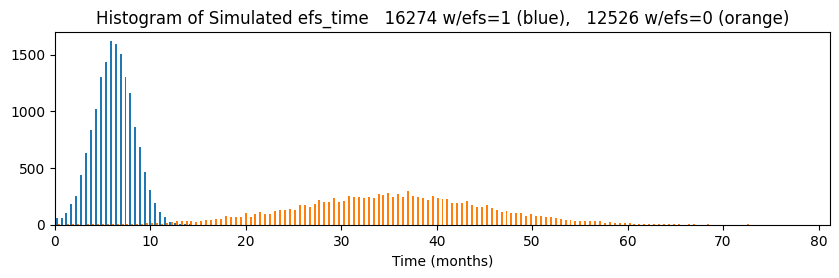


Simulated probability of failure by race_group: [0.46, 0.5, 0.54, 0.58, 0.62, 0.66]

Scores for different risk predictions

risk_pred = -1*efs_time
C Score = 1.0000 (std=0.0000, total=1.0000) from:  [1.]

risk_pred -1*efs_time_err, t_error is normal with std = 2.0 months
C Score = 0.9081 (std=0.0000, total=0.9081) from:  [0.9081]

risk_pred = efs_time < 8.00
C Score = 0.8241 (std=0.0000, total=0.8241) from:  [0.8241]

risk_pred = efs_time_err < 8.00
C Score = 0.7927 (std=0.0000, total=0.7927) from:  [0.7927]

risk_pred = efs
C Score = 0.8461 (std=0.0000, total=0.8461) from:  [0.8461]

risk_pred = will_fail
C Score = 0.8459 (std=0.0000, total=0.8459) from:  [0.8459]

risk_pred = will_fail_err    has p_error = 0.10
C Score = 0.7742 (std=0.0000, total=0.7742) from:  [0.7742]


In [41]:
# Modify risk_true with simulated values, adding other columns (ignored by scorer).
import matplotlib.pyplot as plt
# Simulation Parameters
#
# Prob by race that efs would be 1 if there were no censoring.
# This is a race population parameter, each individual will either fail or not.
prace_fail = [0.46, 0.50, 0.54, 0.58, 0.62, 0.66]
# mean and sd of failure times
mufail = 6.3
sdfail = 2.1
# mean and sd of censor times
mucensor = 35.0
sdcensor = 10.0


np.random.seed(17)

# Put the prace_fail values into the dataframe
risk_true['prace_fail'] = 0.0  # all 0s should be overwritten
for irace, this_race in enumerate(rgroups):
    risk_true.loc[risk_true['race_group'] == this_race, 'prace_fail'] = prace_fail[irace]
# Set who will fail based on their race's fail probability.
risk_true["will_fail"] = 1.0*(np.random.rand(nsamps) < risk_true['prace_fail'])
# Assign ftime, use a large value for ones that won't fail
risk_true["ftime"] = ( risk_true["will_fail"]*np.abs(mufail+sdfail*np.random.randn(nsamps)) +
                          (1.0-risk_true["will_fail"])*1000.0 )
# Assign ctime
risk_true["ctime"] = np.abs(mucensor + sdcensor*np.random.randn(nsamps))
# Set efs_time as the min of ftime and ctime
risk_true["efs_time"] = np.min(risk_true[['ftime','ctime']],axis=1)
# Set efs: =1 if ftime < ctime (will only happen for will_fail ones); =0 otherwise
risk_true["efs"] = 1.0*(risk_true["ftime"] < risk_true["ctime"])

# Show the simulated dataframe of values
##print(risk_true.head(10))

# Used to define a target, y_time, which is 1 if efs_time < threshold, 0 otherwise.
y_time_thresh = 8.0
# define y_time
risk_true["y_time"] = 1.0*(risk_true["efs_time"] < y_time_thresh)

# efs_time distributions coded by efs = 0, 1
plt.figure(figsize=(10,2.5))
plt.hist([ risk_true.loc[risk_true['efs']==1,'efs_time'],
                 risk_true.loc[risk_true['efs']==0,'efs_time'] ], bins = 150, log=False)
plt.title("Histogram of Simulated efs_time   {} w/efs=1 (blue),   {} w/efs=0 (orange)".format(
            sum(risk_true['efs']==1), sum(risk_true['efs']==0)))
plt.xlabel("Time (months)")
plt.xlim(0,)
plt.savefig("sim_of_efs_time.png")
plt.show()


print("\nSimulated probability of failure by race_group:", prace_fail)

# Compare efs and y_time, similar to real data
##print("\n",pd.crosstab(risk_true["efs"], risk_true["y_time"]))

# C-score for different risk assignments
print("")
print("Scores for different risk predictions") 

print("\nrisk_pred = -1*efs_time")
print_score(-1.0*risk_true['efs_time'])

t_error = 2.0
print("\nrisk_pred -1*efs_time_err, t_error is normal with std = {} months".format(t_error))
efs_time_rand = risk_true['efs_time'] + t_error*np.random.randn(len(risk_true))
print_score(1.0/efs_time_rand)

print("\nrisk_pred = efs_time < {:.2f}".format(y_time_thresh))
print_score(risk_true['y_time'])

print("\nrisk_pred = efs_time_err < {:.2f}".format(y_time_thresh))
print_score(1.0*(efs_time_rand < y_time_thresh))


print("\nrisk_pred = efs")
print_score(risk_true['efs'])

print("\nrisk_pred = will_fail")
print_score(risk_true['will_fail'])

p_error = 0.10
print("\nrisk_pred = will_fail_err    has p_error = {:.2f}".format(p_error))
# Random got_wrong is 1 to assign incorrect will_fail value
got_wrong = np.random.choice([0,1], len(risk_true), replace=True,
                                 p=[1-p_error, p_error])
# got_wrong = 0 leaves it correct, = 1 switches 0-->1 and 1-->0
will_fail_rand = np.abs(risk_true["will_fail"] - got_wrong)
print_score(will_fail_rand)

In [42]:
# *** Put simulated efs_time[_dec], efs, and y_time into train   :)
#     Use this to see results when the features have no correlation with the target.
if False:
    train['efs_time'] = risk_true['efs_time']
    train['efs_time_dec'] = pd.qcut(risk_true['efs_time'], 10, labels=dec_labels)
    train['efs'] = risk_true['efs']
    train['y_time'] = risk_true['y_time']

In [43]:
# (Re-)Setup the metric scorer variables to score a risk predicted for all train data
# call the variables risk since they are dataframes, not a usual y.
risk_true = train[["ID","efs","efs_time","race_group"]].copy()
risk_pred = train[["ID"]].copy()   # will add prediction
# Example:
print('\nC-score truth values for train are set. \nExamples:   predicted risk equals 1/efs_time:')
print_score(1.0/train['efs_time'])
print('     ...    predicted risk equals 1.0*(efs_time < 9):')
print_score(1.0*(train['efs_time'] < 9.0))


C-score truth values for train are set. 
Examples:   predicted risk equals 1/efs_time:
C Score = 1.0000 (std=0.0000, total=1.0000) from:  [1.]
     ...    predicted risk equals 1.0*(efs_time < 9):
C Score = 0.8234 (std=0.0000, total=0.8234) from:  [0.8234]


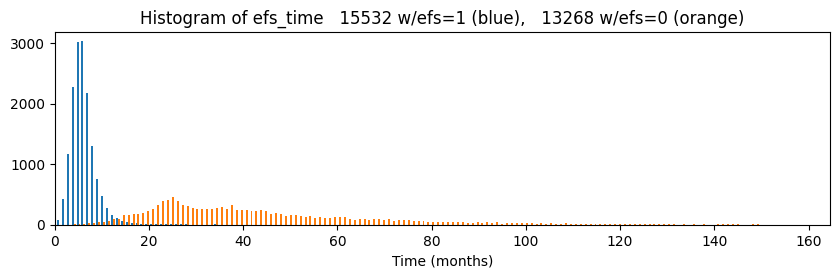

In [44]:
# The "target" values

# efs_time distributions coded by efs = 0, 1
plt.figure(figsize=(10,2.5))
plt.hist([ train.loc[train['efs']==1,'efs_time'],
                 train.loc[train['efs']==0,'efs_time'] ], bins = 150, log=False)
plt.title("Histogram of efs_time   {} w/efs=1 (blue),   {} w/efs=0 (orange)".format(
            sum(train['efs']==1), sum(train['efs']==0)))
plt.xlabel("Time (months)")
plt.xlim(0,)
plt.savefig("hist_of_efs_time.png")
plt.show()

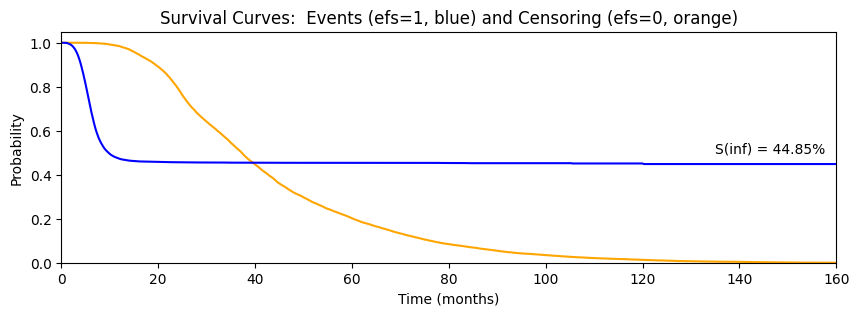

In [45]:
# Calculate the survival curves
s_all_event, s_all_censor, tvals = survivals_from_data(train['efs_time'], train['efs'])

# Other useful things:
s_inf = s_all_event[-1] # late-time survival value
dtval = (tvals[1]-tvals[0])  # delta-t 

plt.figure(figsize=(10,3))
plt.plot(tvals, s_all_censor, c='orange')
plt.plot(tvals, s_all_event, c='blue')
plt.text(135.0,s_inf + 0.05,"S(inf) = {:.2f}%".format(100.0*s_inf))
plt.title("Survival Curves:  Events (efs=1, blue) and Censoring (efs=0, orange)")
plt.xlabel("Time (months)"); plt.ylabel("Probability")
plt.xlim(0,160); plt.ylim(0,1.05)
plt.savefig("survival_curves.png")
plt.show()

In [46]:
# Can do it with lifelines routines - same plot :)
if False:
    kmf = KaplanMeierFitter()
    kmf.fit(train['efs_time'], train['efs'])
    kmf.plot_survival_function(figsize=(10,3), xlim=(0,160), ylim=(0,1.05),c='blue')
    kmf.fit(train['efs_time'], 1.0-train['efs'])
    kmf.plot_survival_function(figsize=(10,3), xlim=(0,160), ylim=(0,1.05),c='orange')
    plt.show()

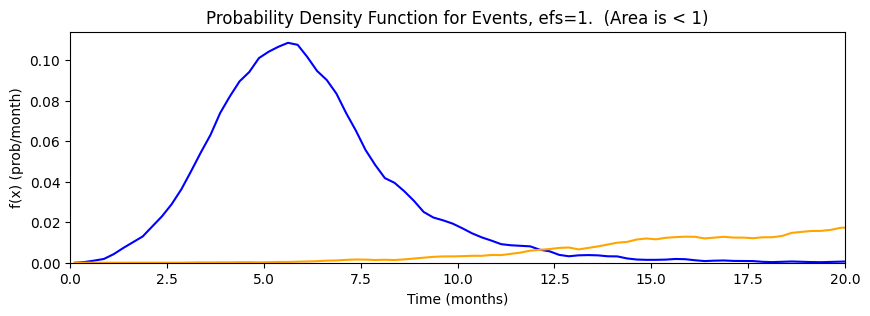

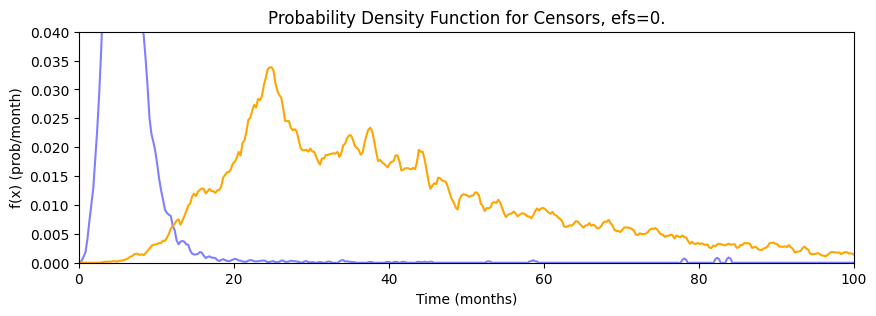

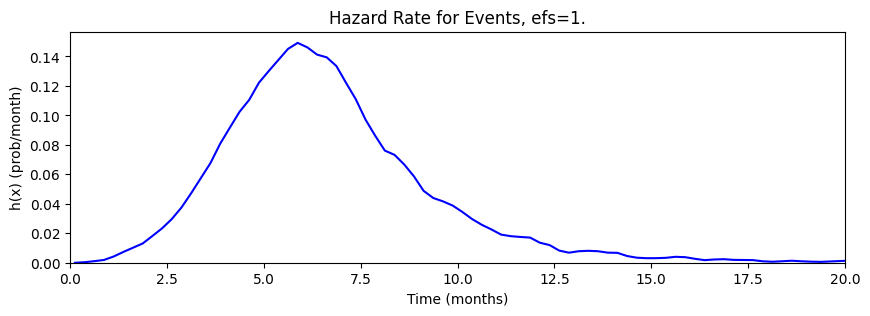

In [48]:
# Calculate the event pdf (does not add to 1) and smooth it
from scipy.signal import savgol_filter
f_all_event = -1*np.diff(s_all_event)/dtval  # prob per month
f_all_event = savgol_filter(f_all_event, 5, 2)
# Calculate the censor pdf and smooth it
f_all_censor = -1*np.diff(s_all_censor)/dtval  # prob per month
f_all_censor = savgol_filter(f_all_censor, 9, 2)
# The times for the pdfs
tmids = tvals[0:-1] + dtval/2.0  # mid-point time 

# Show the probability densities

plt.figure(figsize=(10,3))
plt.plot(tmids, f_all_event, c='blue')
plt.plot(tmids, f_all_censor, c='orange')
plt.xlabel("Time (months)")
plt.ylabel("f(x) (prob/month)")
plt.title("Probability Density Function for Events, efs=1.  (Area is < 1)")
plt.xlim(0,20); plt.ylim(0,)
plt.savefig("pdf_of_events.png")
plt.show()
plt.figure(figsize=(10,3))
plt.plot(tmids, f_all_event, c='blue',alpha=0.5)
plt.plot(tmids, f_all_censor, c='orange')
plt.xlabel("Time (months)")
plt.ylabel("f(x) (prob/month)")
plt.title("Probability Density Function for Censors, efs=0.")
plt.xlim(0,100); plt.ylim(0,0.040)
plt.savefig("pdf_of_censors.png")
plt.show()

# Show the event hazard rate. Put survival on the same tmids grid
s_all_event_mid = (s_all_event[0:-1] + s_all_event[1:])/2.0

plt.figure(figsize=(10,3))
plt.plot(tmids, f_all_event/s_all_event_mid, c='blue')
plt.xlabel("Time (months)")
plt.ylabel("h(x) (prob/month)")
plt.title("Hazard Rate for Events, efs=1.")
plt.xlim(0,20); plt.ylim(0,)
plt.savefig("hazard_of_events.png")
plt.show()

In [49]:
# How separated in time are the efs=0 and efs=1 ?
# efs=1 and efs_time<12 are essentially the same
#             False  True  <-- efs_time < 12
#  efs                   
#  0.0       13030    238
#  1.0         500  15032
##print(pd.crosstab(train["efs"], train['efs_time'] < 12.0))

# The mean times based on pdfs and the mid-bin times
mid_sel = tmids < 25.0  # ignore large outliers
mean_all_event = sum(tmids[mid_sel] * f_all_event[mid_sel])/sum(f_all_event[mid_sel])
# Censors:
mean_all_censor = sum(tmids * f_all_censor)*dtval
print("\n  E[T_event | Event] = {:.2f} , E[T_censor] = {:.2f}".format(mean_all_event, mean_all_censor))


  E[T_event | Event] = 6.16 , E[T_censor] = 43.20


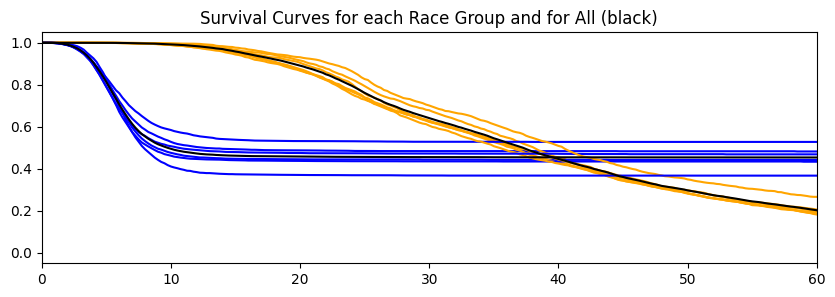


 efs=0    E[T_1]  E[T_0]       Race Group
48.96%     6.33   42.76    blue     American Indian or Alaska Native
44.85%     6.12   42.93    orange   Asian
44.13%     5.95   41.90    green    Black or African-American
53.42%     6.47   42.87    red      More than one race
47.65%     6.17   41.62    purple   Native Hawaiian or other Pacific Islander
37.45%     6.48   47.47    brown    White



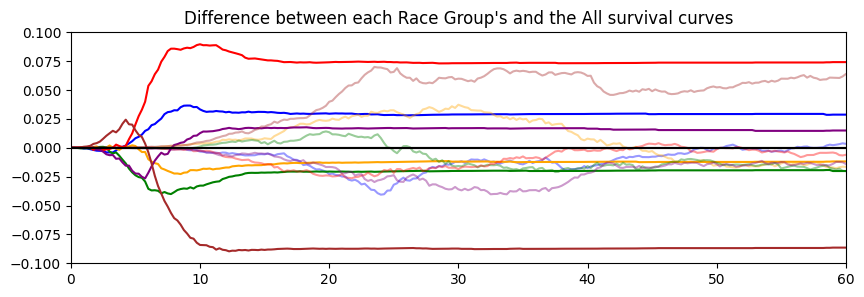

In [52]:
plt.figure(figsize=(10,3))
for irace, this_race in enumerate(rgroups):
    race_sel = train['race_group'] == this_race
    rtime = train.loc[race_sel,'efs_time']
    event_outcome = (train.loc[race_sel,'efs'] == 1)
    censor_outcome = (train.loc[race_sel,'efs'] == 0)
    s_event, s_censor, tvals = survivals_from_data(rtime, 1.0*event_outcome)
    plt.plot(tvals, s_censor - 0*s_all_censor, c='orange')
    plt.plot(tvals, s_event - 0*s_all_event, c='blue')
plt.plot(tvals, s_all_event, c='black')
plt.plot(tvals, s_all_censor, c='black')
plt.xlim(0,60)
plt.title("Survival Curves for each Race Group and for All (black)")
plt.savefig("survival_curves_by_race.png")
plt.show()
print("\n efs=0    E[T_1]  E[T_0]       Race Group")
for irace, this_race in enumerate(rgroups):
    race_sel = train['race_group'] == this_race
    rtime = train.loc[race_sel,'efs_time']
    event_outcome = (train.loc[race_sel,'efs'] == 1)
    censor_outcome = (train.loc[race_sel,'efs'] == 0)
    mean_efs1_time = (np.sum(event_outcome * rtime) /
                         np.sum(event_outcome) )
    mean_efs0_time = (np.sum(censor_outcome * rtime) /
                         np.sum(censor_outcome) )
    print("{:.2f}%     {:.2f}   {:.2f}    {:7}  {}".format(
                100.0*np.mean(censor_outcome), mean_efs1_time, mean_efs0_time,
                        rcolors[irace], this_race))
print()

plt.figure(figsize=(10,3))
for irace, this_race in enumerate(rgroups):
    race_sel = train['race_group'] == this_race
    rtime = train.loc[race_sel,'efs_time']
    event_outcome = (train.loc[race_sel,'efs'] == 1)
    censor_outcome = (train.loc[race_sel,'efs'] == 0)
    s_event, s_censor, tvals = survivals_from_data(rtime, 1.0*event_outcome)
    plt.plot(tvals, s_censor - 1*s_all_censor, c=rcolors[irace], alpha=0.4)
    plt.plot(tvals, s_event - 1*s_all_event, c=rcolors[irace])
plt.plot(tvals, 0*s_all_event, c='black')
plt.plot(tvals, 0*s_all_censor, c='black')
plt.xlim(0,60)
plt.ylim(-0.100,0.100)
plt.title("Difference between each Race Group's and the All survival curves")
plt.savefig("survival_curve_differences.png")
plt.show()

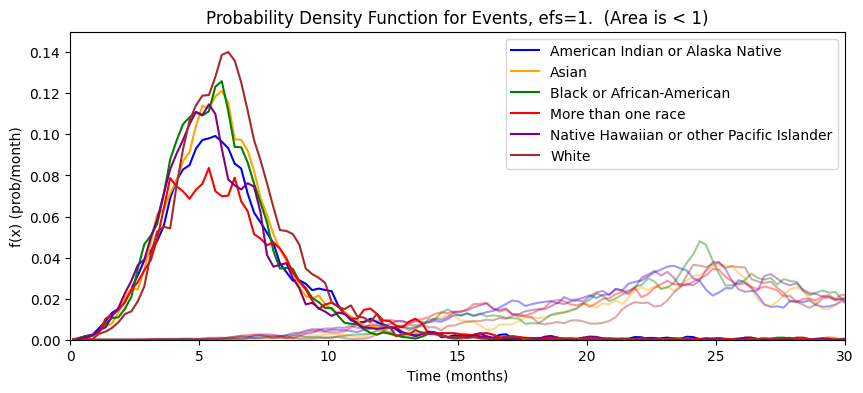

In [54]:
# Show the pdfs by race
plt.figure(figsize=(10,4))
for irace, this_race in enumerate(rgroups):
    race_sel = train['race_group'] == this_race
    rtime = train.loc[race_sel,'efs_time']
    event_outcome = (train.loc[race_sel,'efs'] == 1)
    censor_outcome = (train.loc[race_sel,'efs'] == 0)
    s_event, s_censor, tvals = survivals_from_data(rtime, 1.0*event_outcome)
    
    # Calculate the event pdf (does not add to 1)
    f_event = -1*np.diff(s_event)/dtval  # prob per month
    f_event = savgol_filter(f_event, 5, 2)
    # Calculate the censor pdf and smooth it
    f_censor = -1*np.diff(s_censor)/dtval  # prob per month
    f_censor = savgol_filter(f_censor, 9, 2)
    # The times for the pdfs
    tmids = tvals[0:-1] + dtval/2.0  # mid-point time
    
    plt.plot(tmids, f_event, c=rcolors[irace],label=this_race)
    plt.plot(tmids, f_censor, c=rcolors[irace],alpha=0.4)
    plt.xlabel("Time (months)")
    plt.ylabel("f(x) (prob/month)")
    plt.title("Probability Density Function for Events, efs=1.  (Area is < 1)")
    plt.xlim(0,30); plt.ylim(0,0.15)
    plt.legend()

plt.savefig("pdfs_by_race.png")
plt.show() 

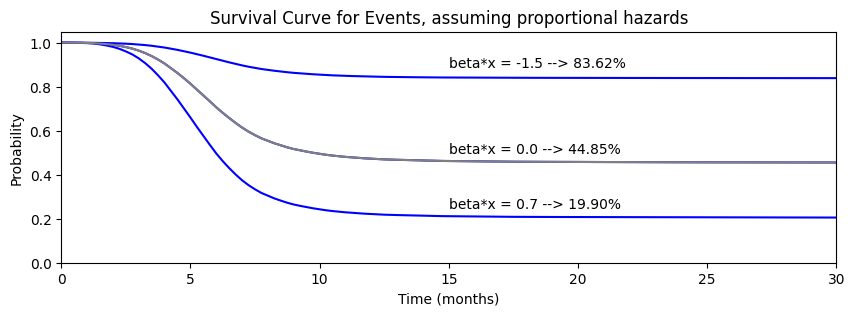

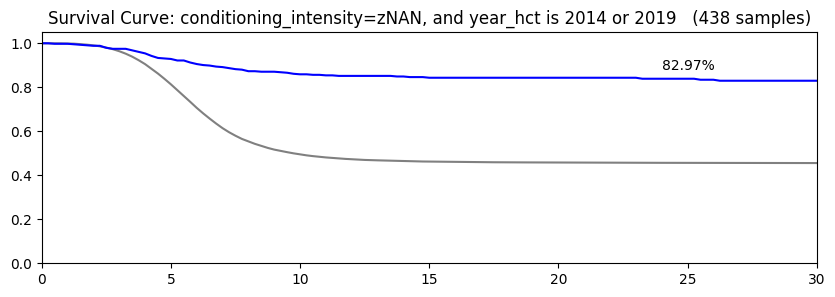

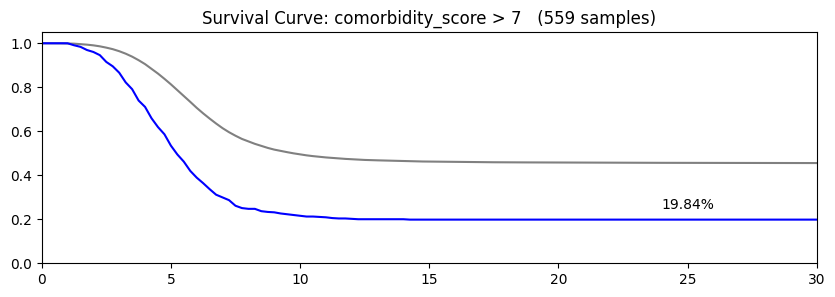

In [58]:
# Demonstrate the effect of proportional hazard on S(t)

plt.figure(figsize=(10,3))
for beta in [-1.5, 0.0, 0.7]:
    plt.plot(tvals, (s_all_event)**np.exp(beta), c='blue')
    this_inf = s_inf**np.exp(beta)
    plt.text(15.0, this_inf + 0.05, "beta*x = {} --> {:.2f}%".format(beta, 100.0*this_inf))
plt.plot(tvals, s_all_event, c='gray')
plt.title("Survival Curve for Events, assuming proportional hazards")
plt.xlabel("Time (months)"); plt.ylabel("Probability")
plt.xlim(0,30); plt.ylim(0,1.05)
plt.savefig("proportional_hazard.png")
plt.show()

# Look at actual survival curves for selected subsets of the features

# Choose features to have reduced risk:
featset_sel = ( (train['conditioning_intensity'] == "zNAN") &
                  ((train['year_hct'] == 2014) | (train['year_hct'] == 2019)) )
feat_info = "conditioning_intensity=zNAN, and year_hct is 2014 or 2019"

rtime = train.loc[featset_sel,'efs_time']
event_outcome = (train.loc[featset_sel,'efs'] == 1)
censor_outcome = (train.loc[featset_sel,'efs'] == 0)
s_event, s_censor, tvals = survivals_from_data(rtime, 1.0*event_outcome)
this_inf = s_event[-1]
plt.figure(figsize=(10,3))
plt.plot(tvals, s_all_event, c='gray')
plt.plot(tvals, s_event, c='blue')
plt.text(24.0, this_inf + 0.05, "{:.2f}%".format(100.0*this_inf))
plt.title("Survival Curve: " + feat_info + "   ({} samples)".format(sum(featset_sel)))
plt.xlim(0,30), plt.ylim(0.0,1.05)
plt.savefig("survival_reduced_risk.png")
plt.show()

# Choose features for high risk:
featset_sel = (train['comorbidity_score'] > 7.0) & (train['comorbidity_score'] < 11.0)
feat_info = "comorbidity_score > 7"

rtime = train.loc[featset_sel,'efs_time']
event_outcome = (train.loc[featset_sel,'efs'] == 1)
censor_outcome = (train.loc[featset_sel,'efs'] == 0)
s_event, s_censor, tvals = survivals_from_data(rtime, 1.0*event_outcome)
this_inf = s_event[-1]

plt.figure(figsize=(10,3))
plt.plot(tvals, s_all_event, c='gray')
plt.plot(tvals, s_event, c='blue')
plt.text(24.0, this_inf + 0.05, "{:.2f}%".format(100.0*this_inf))
plt.title("Survival Curve: " + feat_info + "   ({} samples)".format(sum(featset_sel)))
plt.xlim(0,30), plt.ylim(0.0,1.05)
plt.savefig("survival_high_risk.png")
plt.show()


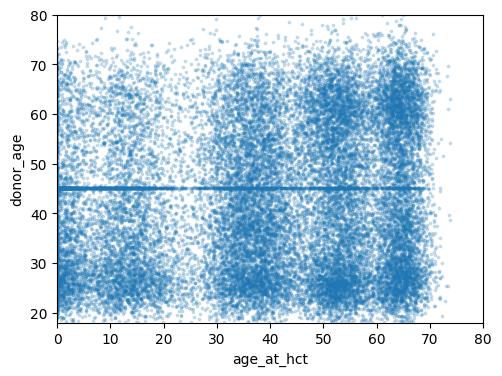

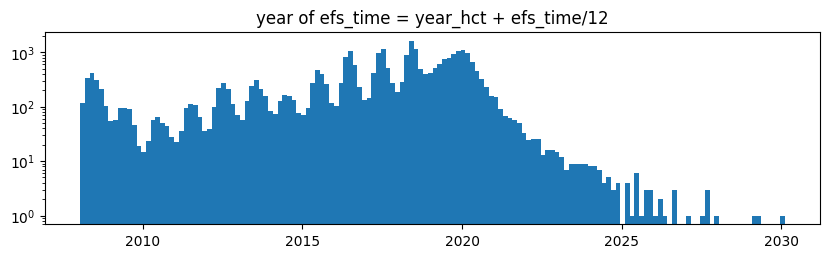

In [59]:
# The age distributions
# Compare the patient and donor ages
train.plot.scatter('age_at_hct','donor_age',alpha=0.2,s=3,
                   figsize=(5.5,4),xlim=(0,80),ylim=(18,80))
plt.savefig("age_vs_age.png")
plt.show()

# Year of the latest efs_time is 2030  :)
plt.figure(figsize=(10,2.5))
plt.hist(train['year_hct'] + train['efs_time']/12.0, bins = 150, log=True)
plt.title("year of efs_time = year_hct + efs_time/12")
plt.savefig("hist_of_efs_time_year.png")
plt.show()

In [61]:
# The decile-grouped values are useful here.
from scipy.stats import chi2_contingency
rowcol = "y_time"  # "race_group" "efs" "y_time"
print("       Chi2 Test vs {}".format(rowcol),9*" ","signif: -- low  *** high")
print(14*" ","number unique          p-value ") # also put value in code below
for icol, colcol in enumerate(train.columns):
    # Make contingency table, rowcol then colcol
    crosstab = pd.crosstab(train[rowcol], train[colcol])
    ##print(crosstab)

    # Get the p-value using:
    #   https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.stats.chi2_contingency.html
    # Returns object containing 3 floats and the expected crosstab:
    #   statistic  pvalue  dofint  expected_freq
    chi2_results = chi2_contingency(crosstab)
    pvalue = chi2_results.pvalue
    num_unique = len(train[colcol].unique())
    flag_str = ""
    if pvalue < 1e-20: flag_str = "  ***"
    elif pvalue > 0.01: flag_str = "--"
    if num_unique < 100e3:  # 100 = don't show the 'continuous' variables
        print("{:2} {:24} {:6} {:12.4g} {}".format
          (icol, colcol, num_unique, pvalue, flag_str))


       Chi2 Test vs y_time           signif: -- low  *** high
               number unique          p-value 
 0 ID                        28800       0.4972 --
 1 dri_score                    11   2.637e-241   ***
 2 psych_disturb                 4    6.988e-26   ***
 3 cyto_score                    8   2.431e-206   ***
 4 diabetes                      4    2.609e-39   ***
 5 hla_match_c_high              4     0.001655 
 6 hla_high_res_8                6    0.0001319 
 7 tbi_status                    8    2.475e-15 
 8 arrhythmia                    4    4.983e-19 
 9 hla_low_res_6                 5    3.532e-08 
10 graft_type                    2   8.167e-191   ***
11 vent_hist                     3      0.01221 --
12 renal_issue                   4    4.848e-05 
13 pulm_severe                   4    5.888e-38   ***
14 prim_disease_hct             17   1.838e-291   ***
15 hla_high_res_6                5    0.0002641 
16 cmv_status                    5    2.538e-56   ***
17 hla_high_re

In [62]:
# Define the X by choosing the feature columns

# All features
Xcols = categ_cols + numer_cols
# Two ages are included as continuous values and as decile categories
# For LR use the categories (will be one-hots) so drop the ages:
Xcols.remove('age_at_hct'); Xcols.remove('donor_age')

# Remove the 6 with chi2>0.01 when vs y_time.  Not useful to predict early efs?
##for icol in [11,18,21,24,45,52]:
# Remove the 8 with chi2>0.01 when vs efs.  Not useful to predict survival?
##for icol in [11,22,34,40,41,43,49,52]:
##    Xcols.remove(train.columns[icol])

# An experiment  ******************
Xcols.remove('rituximab')

In [66]:
# Assemble the X (and Xtest)
X = train[Xcols].copy()
Xtest = test[Xcols].copy()

# Convert to one-hot for all except age_at_hct and donor_age.
for this_col in Xcols:
    if not(this_col in ['age_at_hct','donor_age']):
        # Get one hot encoding of this_col
        # Categories are done in alpha/numer order. Prefixx "++" will
        one_hot = pd.get_dummies(X[this_col],prefix=this_col,prefix_sep=" = ",
                                dtype=float, drop_first=True)
        ##print(one_hot.columns)
        X = X.drop(this_col,axis = 1)
        X = X.join(one_hot)
        # Do it to Xtest too
        one_hot = pd.get_dummies(Xtest[this_col],prefix=this_col,prefix_sep=" = ",
                                dtype=float, drop_first=True)
        Xtest = Xtest.drop(this_col,axis = 1)
        Xtest = Xtest.join(one_hot)
        
        
        # Check that X and Xtest have the same columns and categories, depends on Xcols.
# May happen for rare categories which are not in both?
# Only checks the number not the actual column names... (Should use set differences...)
num_X = len(X.columns)
num_Xtest = len(Xtest.columns)
if num_X > num_Xtest:
    # Drop the extra column(s) from X
    extra_cols = set(X.columns) - set(Xtest.columns)
    X = X.drop(columns=extra_cols)
    num_X = len(X.columns)
    num_Xtest = len(Xtest.columns)
    print("Removed {} col(s) from X.  Now X has {} and Xtest has {} columns\n".format(
        len(extra_cols), num_X, num_Xtest))
elif num_Xtest > num_X:
    
    # Drop the extra column(s) from Xtest
    extra_cols = set(Xtest.columns) - set(X.columns)
    Xtest = Xtest.drop(columns=extra_cols)
    num_X = len(X.columns)
    num_Xtest = len(Xtest.columns)
    print("Removed {} col(s) from Xtest.  Now X has {} and Xtest has {} columns\n".format(
        len(extra_cols), num_X, num_Xtest)) 

print("\nCreated X and Xtest from {} columns, giving {} (one-hot) features.\n".format(
                        len(Xcols),len(X.columns)))


Created X and Xtest from 56 columns, giving 257 (one-hot) features.



In [67]:
# For logistic regression, can use two slightly different targets: (for both, high risk = 1)
ye = train['efs'].copy()
time_threshold = 7.72
train['y_time'] = 1.0*(train['efs_time'] < time_threshold)
yt = train['y_time'].copy()
# Compare the targets
print(pd.crosstab(ye,yt))

y_time    0.0    1.0
efs                 
0.0     13214     54
1.0      3201  12331


In [70]:

from sklearn.linear_model import LogisticRegression
print("\nDoing Logistic Regression ...\n")

# Use a small amount of l1 regularization (smaller is more reg.)
##Creg = 0.30; reg_type = "l1"   # ~ 35 coefs are zero
Creg = 0.60; reg_type = "l1"   # ~ 15 coefs are zero
##Creg = 10; reg_type = "l2"    # essentiall no regularization

ye_prob = np.zeros(len(X))
testye_prob = np.zeros(len(Xtest))
lrm_e = LogisticRegression(penalty=reg_type,tol=1e-5, C=Creg,  # C smaller-->more regularization
                            fit_intercept=True, intercept_scaling = 10.0,  # large reduces regul. 
                            random_state=0, solver='liblinear',
                            max_iter=100, n_jobs=None, verbose=0).fit(X, ye)
print("ye:",15*" ","LRe score = {:.4f}  ({} iters, {} coef.s are 0)".format(
            lrm_e.score(X, ye), lrm_e.n_iter_[0], sum(np.abs(lrm_e.coef_[0]) < 1e-6)))
ye_prob = (lrm_e.predict_proba(X))[:,1]
testye_prob = (lrm_e.predict_proba(Xtest))[:,1]
print_score(ye_prob)


yt_prob = np.zeros(len(X))
testyt_prob = np.zeros(len(Xtest))
lrm_t = LogisticRegression(penalty=reg_type,tol=1e-5, C=Creg,  # C smaller-->more regularization
                            fit_intercept=True, intercept_scaling = 10.0,  # large reduces regul. 
                            random_state=0, solver='liblinear',
                            max_iter=100, n_jobs=None, verbose=0).fit(X, yt)
print("yt:",15*" ","LRt score = {:.4f}  ({} iters, {} coef.s are 0)".format(
            lrm_t.score(X, yt), lrm_t.n_iter_[0], sum(np.abs(lrm_t.coef_[0]) < 1e-6)))
yt_prob = (lrm_t.predict_proba(X))[:,1]
testyt_prob = (lrm_t.predict_proba(Xtest))[:,1]
print_score(yt_prob)


Doing Logistic Regression ...

ye:                 LRe score = 0.7006  (20 iters, 16 coef.s are 0)
C Score = 0.6801 (std=0.0000, total=0.6801) from:  [0.6801]
yt:                 LRt score = 0.6870  (19 iters, 15 coef.s are 0)
C Score = 0.6896 (std=0.0000, total=0.6896) from:  [0.6896]


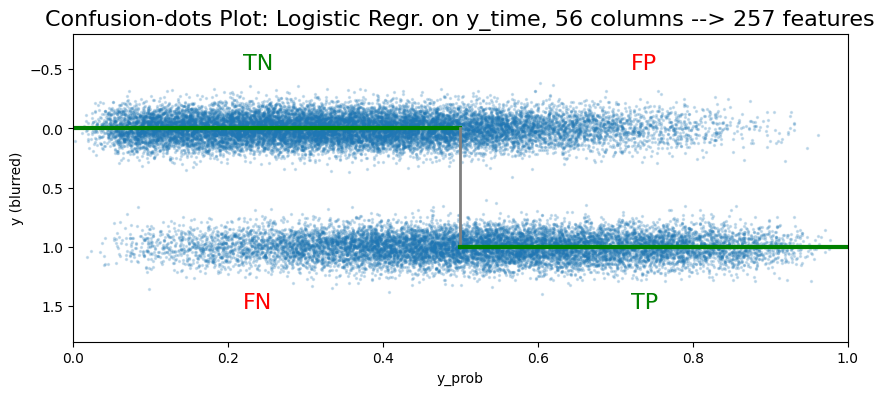

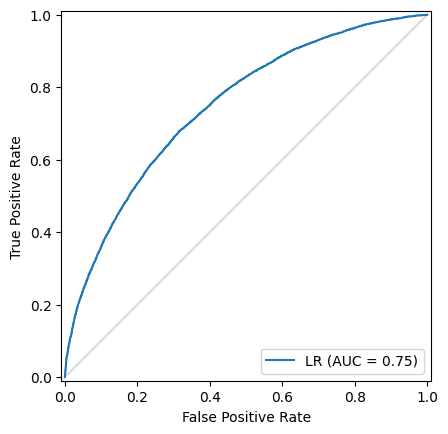

In [71]:
# Show the Confusion Dots and ROC curve.
confusion_dots_roc(yt, yt_prob, 'Logistic Regr. on y_time, {} columns --> {} features'.format(
        len(Xcols),len(X.columns)), 'LR', plots_prefix="LR_yt_model")

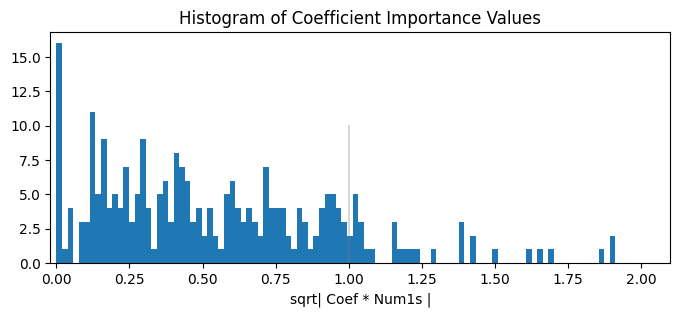

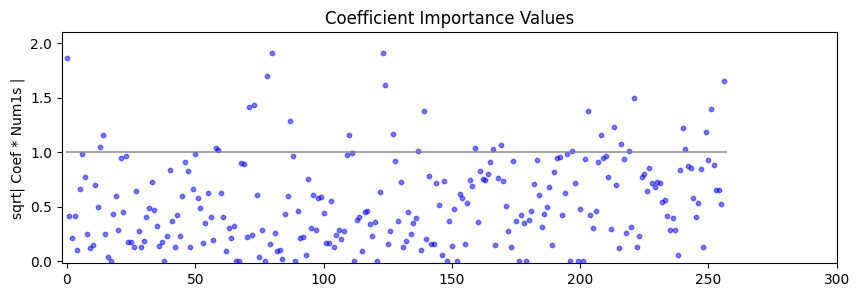

In [72]:
# Use the y_time LR coef.s to find significant ones.
lrt_coefs = lrm_t.coef_[0]
#The ohe feature names
feat_names = lrm_t.feature_names_in_
feat_number = len(feat_names)
# For each feature, get the number of "1"s in its column in all the train data.
feat_num1s = []
for ifeat, feat_name in enumerate(feat_names):
  feat_num1s.append(X[feat_name].sum())  
feat_num1s = np.array(feat_num1s) / 1000.0   # scaled by 1000



# Create the coef*num1s/1000 product as a measure of the feature importance:
feat_imports = lrt_coefs * feat_num1s
# For histograms and plotting use this
sqrt_imports = np.sqrt(np.abs(feat_imports))

coef_signif = 1.00  # np.quantile(sqrt_imports, 0.850)

plt.figure(figsize=(8,3))
plt.plot(2*[coef_signif],[0,10],alpha=0.3,c='gray')
plt.hist(sqrt_imports, bins=100)
plt.xlabel("sqrt| Coef * Num1s |")
plt.xlim(-0.02,2.1)
plt.title("Histogram of Coefficient Importance Values")
plt.savefig("LR_model_coefs_hist.png")
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(range(feat_number), sqrt_imports, s=10, c='blue', alpha=0.5)
plt.plot([0,feat_number],[coef_signif,coef_signif],c='gray', alpha=0.7)
plt.ylabel("sqrt| Coef * Num1s |")
plt.ylim(-0.02,2.1)
plt.xlim(-2,300)
plt.title("Coefficient Importance Values")
plt.savefig("LR_model_importance.png")
plt.show()


ifeat  import   num1s(k)   Feature = Category                           Percent of 1s by race_group
 166     1.06     2.88    age_at_hct_dec = Q10                     15.9  20.0  13.8  12.7  17.5  20.0
 159     1.07     2.88    age_at_hct_dec = Q3                      18.0  13.7  16.9  19.5  17.7  14.3
  58    -1.07    4.048    cmv_status = +/-                         16.4  17.1  14.9  18.6  15.5  17.5
  59     1.05    7.081    cmv_status = -/+                         16.3  14.2  15.4  16.2  16.2  21.6
  78     2.89    7.722    conditioning_intensity = RIC             15.2  20.8  15.0  13.3  16.4  19.4
  80    -3.65    4.789    conditioning_intensity = zNAN            19.9  12.8  19.1  25.7  13.7   8.7
  13    -1.09    3.011    cyto_score = Favorable                   14.9  19.7  13.8  12.2  16.3  23.0
  14    -1.33    6.376    cyto_score = Intermediate                14.8  17.0  16.3  14.4  16.4  21.1
  71     2.00   11.158    cyto_score_detail = Intermediate         14.9  17.9  15.6

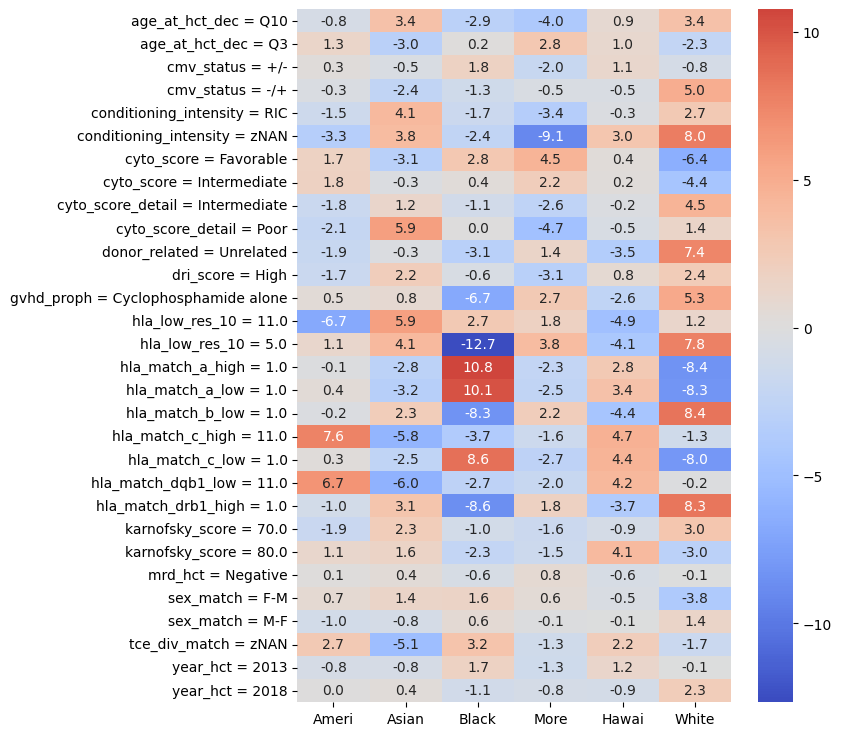

In [74]:
print("\nifeat  import   num1s(k)   Feature = Category",
         25*" ","Percent of 1s by race_group")
hmap_index = []
hmap_vals = []
for ifeat in np.argsort(feat_names):
    if sqrt_imports[ifeat] > coef_signif:   # doing the selection here
        # determine the percent in each race_group:
        col_name, cat_name = feat_names[ifeat].split(" = ")
        if col_name not in categ_cols:
            # convert string to numeric
            cat_name = float(cat_name)
        pct_by_race = np.array(pd.crosstab(train['race_group'],train[col_name])[cat_name])
        pct_by_race = 100.0*pct_by_race/pct_by_race.sum()
        print("{:4} {:8.2f} {:8}    {:38} ".format(
                        ifeat, feat_imports[ifeat], feat_num1s[ifeat], feat_names[ifeat])+
                 "{:6.1f}{:6.1f}{:6.1f}{:6.1f}{:6.1f}{:6.1f}".format(*pct_by_race))
        if col_name != 'race_group':   # don't include race_group onehots
            hmap_index.append(feat_names[ifeat])
            hmap_vals.append(np.sign(lrt_coefs[ifeat])*(pct_by_race - 16.666))

# Show the table above as a heatmap
print("\n\nHeat map of: Sign(LRt coef)*(Race Percentage - 16.7%)",
              ":            Red = higher risk")
hmap_cols = ['Ameri', 'Asian', 'Black', 'More', 'Hawai', 'White']
df = pd.DataFrame(hmap_vals, index=hmap_index, columns=hmap_cols)
import seaborn as sns



plt.figure(figsize=(7,9))
sns.heatmap(df, annot=True, fmt=".1f", cmap="coolwarm", center=0.0)
plt.savefig("LR_coef_imports_heatmap.png")
plt.show()

In [76]:
# Do fits for each race_group separately, combine results into one yr*
rgroups = ['American Indian or Alaska Native', 'Asian', 'Black or African-American',
              'More than one race', 'Native Hawaiian or other Pacific Islander', 'White']
race_e_coefs = []  # save these
race_t_coefs = []
no_race_cols = [xcol for xcol in X.columns if "race_group" not in xcol]

# Inititalize the prediction probabilities
yre_prob = np.zeros(len(X))
yrt_prob = np.zeros(len(X))
testyre_prob = np.zeros(len(Xtest))
testyrt_prob = np.zeros(len(Xtest))

print("\nDoing Logistic Regression by race_group ...\n")


# Use a medium-large amount of l1 regularization (smaller is more reg.)
##Creg = 0.70;  reg_type = "l1"    # ~ 50-60 coefs are zero
Creg = 1.20;  reg_type = "l1"    # ~ 25-35 coefs are zero
# essentially no regularization
##Creg = 10.0;  reg_type = "l2"

# X without the race onehots
Xr_all = X[no_race_cols]
for this_race in rgroups:
    # Use the train/test to select for the race
    race_sel = train['race_group'] == this_race
    test_sel = test['race_group'] == this_race
    Xr = X.loc[race_sel, no_race_cols]
    Xr_test = Xtest.loc[test_sel, no_race_cols]
    yre = ye[race_sel]
    yrt = yt[race_sel]

    # Fit the model (reused for each race group)
    lrm_re = LogisticRegression(penalty=reg_type,tol=1e-5, C=Creg,  # C smaller-->more regularization
                                
                                       fit_intercept=True, intercept_scaling = 10.0,  # large reduces regul. 
                            random_state=0, solver='liblinear',
                            max_iter=100, n_jobs=None, verbose=0).fit(Xr, yre)
    print("LRe score = {:.4f}  ({:3} iters, {} coef.s are 0)".format(
            lrm_re.score(Xr, yre), lrm_re.n_iter_[0], sum(np.abs(lrm_re.coef_[0]) < 1e-6)),
              "y=0 is {:.2f}%   ".format(100.0*sum(yre == 0)/len(yre)) + this_race)
    # Save these values
    yre_prob[race_sel] = (lrm_re.predict_proba(Xr))[:,1]
    race_e_coefs.append(lrm_re.coef_[0])
    # Make the test predictions
    testyre_prob[test_sel] = (lrm_re.predict_proba(Xr_test))[:,1]
    
# to 0 1 range
if False:
    yre_prob = values_logisticized(yre_prob)
    testyre_prob = values_logisticized(testyre_prob)
    yrt_prob = values_logisticized(yrt_prob)
    testyrt_prob = values_logisticized(testyrt_prob)

print("\nyre:")
print_score(yre_prob)
print("yrt:")
print_score(yrt_prob)
    


Doing Logistic Regression by race_group ...

LRe score = 0.7234  ( 21 iters, 29 coef.s are 0) y=0 is 48.96%   American Indian or Alaska Native
LRe score = 0.7192  ( 22 iters, 28 coef.s are 0) y=0 is 44.85%   Asian
LRe score = 0.7107  ( 22 iters, 34 coef.s are 0) y=0 is 44.13%   Black or African-American
LRe score = 0.7092  ( 23 iters, 36 coef.s are 0) y=0 is 53.42%   More than one race
LRe score = 0.7072  ( 20 iters, 27 coef.s are 0) y=0 is 47.65%   Native Hawaiian or other Pacific Islander
LRe score = 0.7350  ( 16 iters, 37 coef.s are 0) y=0 is 37.45%   White

yre:
C Score = 0.6896 (std=0.0000, total=0.6896) from:  [0.6896]
yrt:
C Score = 0.5000 (std=0.0000, total=0.5000) from:  [0.5]


In [94]:
rcolors = ['red','blue','green','orange','purple','brown']
print(f"rcolors:{rcolors}")

rcolors:['red', 'blue', 'green', 'orange', 'purple', 'brown']


Features from model: ['Feature1' 'Feature2']
Columns in Xr_all: ['Feature1', 'Feature2']
Error: race_coefs is empty!


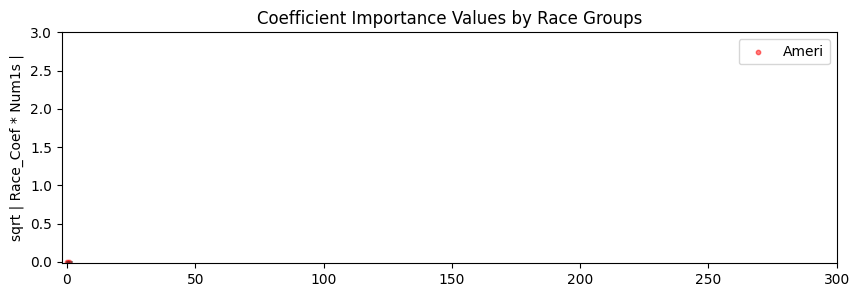

In [101]:



# Use the y_time LR by-race coef.s to find significant ones and variations.
  # 2D: irace, ifeat
from sklearn.linear_model import LogisticRegression
lrm_rt = LogisticRegression()

import pandas as pd

X_train = pd.DataFrame([[1, 2], [3, 4]], columns=["Feature1", "Feature2"])
y_train = [0, 1]

# Assuming X_train is a DataFrame with named columns
lrm_rt = LogisticRegression().fit(X_train, y_train)  # Fit first!
feat_names_r = lrm_rt.feature_names_in_  # Now works
feat_number_r = len(feat_names_r)
print("Features from model:", feat_names_r)
print("Columns in Xr_all:", Xr_all.columns.tolist())
  
Xr_all = pd.DataFrame(Xr_all, columns=feat_names_r)
# For each feature, get the number of "1"s in its column in all the train data.
feat_num1s_r = []
for ifeat, feat_name in enumerate(feat_names_r):
    
    feat_num1s_r.append(Xr_all[feat_name].sum())  
feat_num1s_r = np.array(feat_num1s_r) / 1000.0   # scaled by 1000

if True:
    race_signif = 1.35
      
    # Same plot with individual race coefs
    plt.figure(figsize=(10,3))
    # usual rcolors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    # Step 1: Define feat_numls_r (if missing)
feat_numls_r = [Xr_all[feat].sum() for feat in feat_names_r]
feat_numls_r = np.array(feat_numls_r) / 1000.0

# Step 2: Run your existing code
race_imports = []
# Ensure race_coefs is properly initialized (example)
  # Replace [...] with your data
race_coefs = np.array(race_t_coefs)
# Run loop only if race_coefs is non-empty
if len(race_coefs) > 0:
    race_imports = []
    for trace in range(len(race_coefs)):  # Dynamic loop range
        these_imports = np.sqrt(np.abs(feat_numls_r * race_coefs[trace]))
        race_imports.append(these_imports)
        plt.scatter(range(feat_number_r), these_imports, 
                    s=10, c=rcolors[trace], alpha=0.5, label=rgroups[trace])
else:
    print("Error: race_coefs is empty!")

      
    plt.scatter(range(feat_number_r), these_imports,
                    s=10, c=rcolors[irace], alpha=0.5, label=rgroups[irace][0:5])
    all_race_imports = np.array(race_imports).flatten(order='K')
    
    plt.plot([0,feat_number_r],[0.0,0.0],c='black',alpha=0.4)
    ##plt.plot([0,feat_number_r],[race_signif,race_signif],c='gray', alpha=0.7)
    plt.ylabel("sqrt | Race_Coef * Num1s |")
    plt.ylim(-0.02,3.0)
    plt.xlim(-2,300)
    plt.title("Coefficient Importance Values by Race Groups")
    plt.legend()
    plt.savefig("LR_by_race_importance.png")
    plt.show()


In [103]:
if True:
    print("\nifeat sqrt(std) num1s(k)   Feature = Category"+17*" "+
          "LR Coefficients - Mean_Coef, by race_group")
    # Which feature--categories have the higher std of coef values across race groups
    race_coefs_mean = race_coefs.mean(axis=0)
    hmap_index = []
    hmap_vals = []
    # Step 1: Compute std_sqrts
std_sqrts = np.std(race_coefs, axis=0)  # Standard deviation across traces

# Step 2: Define your threshold (e.g., 0.1)
std_signif = 0.1  # Adjust based on your needs

# Step 3: Run your existing code
hmap_vals = []
hmap_index = []
for ifeat in np.argsort(feat_names_r):
    if std_sqrts[ifeat] > std_signif:  # Now works!
        hmap_index.append(feat_names_r[ifeat])
        this_coefs = race_coefs[:, ifeat] - race_coefs_mean[ifeat]
    for ifeat in np.argsort(feat_names_r):
        if std_sqrts[ifeat] > std_signif:
            hmap_index.append(feat_names_r[ifeat])
            this_coefs = race_coefs[:,ifeat] - race_coefs_mean[ifeat]
            hmap_vals.append(this_coefs)
            print("{:4} {:7.2f} {:8.2f}    {:32} ".format(
                    ifeat, std_sqrts[ifeat], feat_num1s_r[ifeat], feat_names_r[ifeat])+
                 "{:8.4f}{:8.4f}{:8.4f}{:8.4f}{:8.4f}{:8.4f}".format(*this_coefs))
            
    # Show the table above as a heatmap
    print("\nThe LR-single-race coef values as a heat map:", 10*" ","Red = higher risk")
    hmap_cols = ['Ameri', 'Asian', 'Black', 'More', 'Hawai', 'White']
    df = pd.DataFrame(hmap_vals, index=hmap_index, columns=hmap_cols)

    plt.figure(figsize=(7,9))
    sns.heatmap(df, annot=True, fmt=".3f", cmap="coolwarm", center=0.0)
    plt.savefig("LR_race_coefs_heatmap.png")
    plt.show()


ifeat sqrt(std) num1s(k)   Feature = Category                 LR Coefficients - Mean_Coef, by race_group


IndexError: invalid index to scalar variable.

In [104]:
print("CoxPHFitter includes race_group as one-hots")
# Use the same X as the LR above; race group is included as one-hots
Xy_cox = X.copy()
# The targets
Xy_cox['efs_time'] = train['efs_time']
Xy_cox['efs'] = train['efs']

# No penalty, converges in 6 iterations
cph = CoxPHFitter()
# Include l1 penalty, larger penalizer gives more regularization.
##cph = CoxPHFitter(penalizer=0.0030, l1_ratio=1.0)  # 63 iters. ~ 75 coef.s of 259 are zero.
##cph = CoxPHFitter(penalizer=0.0020, l1_ratio=1.0)  # 60 iters. ~ 53 coef.s of 259 are zero.
cph.fit(Xy_cox, duration_col='efs_time', event_col='efs', show_progress=True)

# The concordance value. Can also do:  cph.score(Xy_cox, scoring_method="concordance_index")
print("\n               C-index {:19.4f} ".format(cph.concordance_index_))
print("        AIC (Cox)/1000 {:19.3f}  (lower is better)".format(cph.AIC_partial_/1000.0))
print("    Number of features {:19} ".format(len(Xy_cox.columns) - 2))

# More details
##cph.print_summary()  # access the individual results using cph.summary

CoxPHFitter includes race_group as one-hots
Iteration 1: norm_delta = 8.13e-01, step_size = 0.9500, log_lik = -154145.54142, newton_decrement = 3.48e+03, seconds_since_start = 11.1
Iteration 2: norm_delta = 2.22e-01, step_size = 0.9500, log_lik = -150928.04409, newton_decrement = 2.78e+02, seconds_since_start = 20.8
Iteration 3: norm_delta = 4.62e-02, step_size = 0.9500, log_lik = -150635.07838, newton_decrement = 8.77e+00, seconds_since_start = 30.5
Iteration 4: norm_delta = 3.56e-03, step_size = 1.0000, log_lik = -150626.02384, newton_decrement = 3.39e-02, seconds_since_start = 41.4
Iteration 5: norm_delta = 7.01e-05, step_size = 1.0000, log_lik = -150625.98962, newton_decrement = 8.33e-06, seconds_since_start = 52.0
Iteration 6: norm_delta = 5.08e-08, step_size = 1.0000, log_lik = -150625.98961, newton_decrement = 4.14e-12, seconds_since_start = 62.7
Convergence success after 6 iterations.

               C-index              0.6875 
        AIC (Cox)/1000             301.766  (lowe

In [105]:
# Start with same X as LR above but drop the race_group one-hots and add race_group categories.
Xyr_cox = X[no_race_cols].copy()
Xyr_cox['race_group'] = train['race_group']
# Same for test
Xrtest = Xtest[no_race_cols].copy()
Xrtest['race_group'] = test['race_group']
# The targets
Xyr_cox['efs_time'] = train['efs_time']
Xyr_cox['efs'] = train['efs']

# No penalty, converges in 6 iterations
cphr = CoxPHFitter()
# Include l1 penalty, larger penalizer gives more regularization.
##cphr = CoxPHFitter(penalizer=0.0030, l1_ratio=1.0)  # 64 iters. ~ 75 coef.s of 255 are zero.
##cphr = CoxPHFitter(penalizer=0.0020, l1_ratio=1.0)  # 61 iters. ~ 53 coef.s of 255 are zero.
cphr.fit(Xyr_cox, duration_col='efs_time', event_col='efs',
                             strata=['race_group'], show_progress=True)

# The concordance value. Can also do:  cphr.score(Xy_cox, scoring_method="concordance_index")
print("\n w/Race Strata        C-index {:19.4f} ".format(cphr.concordance_index_))
print("               AIC (Cox)/1000 {:19.3f}  (lower is better)".format(cphr.AIC_partial_/1000.0))
print("           Number of features {:19} ".format(len(Xyr_cox.columns) - 2))

# More details
##cphr.print_summary()  # access the individual results using cph.summary


Iteration 1: norm_delta = 8.15e-01, step_size = 0.9500, log_lik = -126243.62639, newton_decrement = 3.38e+03, seconds_since_start = 7.1
Iteration 2: norm_delta = 2.17e-01, step_size = 0.9500, log_lik = -123122.51634, newton_decrement = 2.57e+02, seconds_since_start = 14.2
Iteration 3: norm_delta = 4.41e-02, step_size = 0.9500, log_lik = -122850.96542, newton_decrement = 7.87e+00, seconds_since_start = 21.2
Iteration 4: norm_delta = 3.20e-03, step_size = 1.0000, log_lik = -122842.85272, newton_decrement = 2.81e-02, seconds_since_start = 28.3
Iteration 5: norm_delta = 5.70e-05, step_size = 1.0000, log_lik = -122842.82441, newton_decrement = 5.56e-06, seconds_since_start = 35.5
Iteration 6: norm_delta = 3.40e-08, step_size = 1.0000, log_lik = -122842.82440, newton_decrement = 1.85e-12, seconds_since_start = 42.7
Convergence success after 6 iterations.

 w/Race Strata        C-index              0.6850 
               AIC (Cox)/1000             246.190  (lower is better)
           Number 

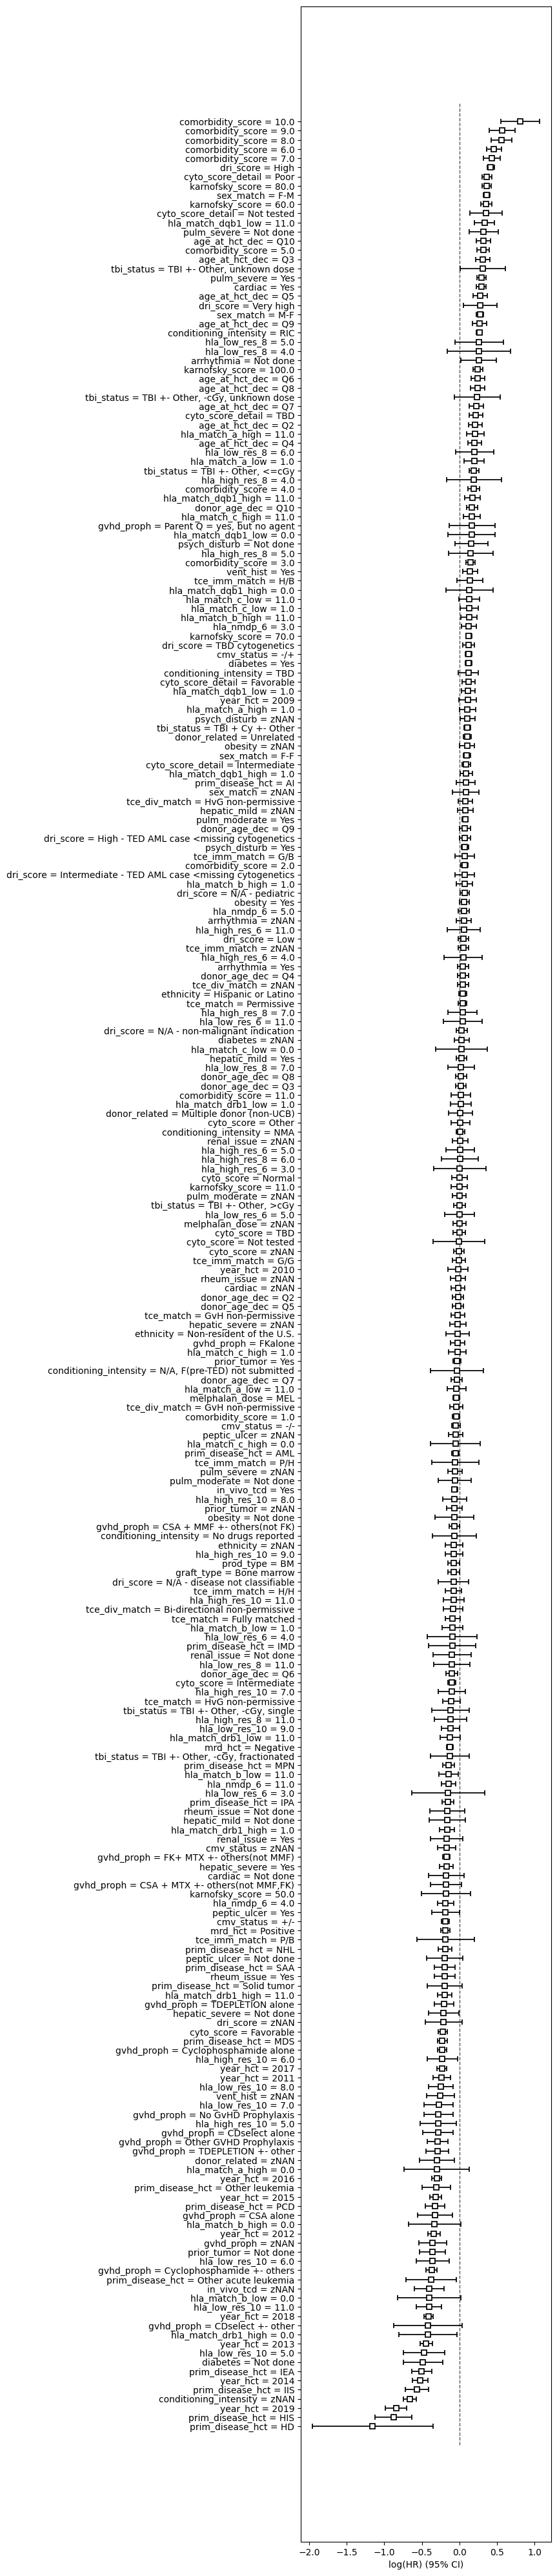

In [106]:
# Graphically show the Coefficient Values = log(Hazard Ratio) for the category
if False:   # without strata
    plt.figure(figsize=(5,30*len(Xy_cox.columns)/150))
    cph.plot()
if True:       # with race_group strata
    plt.figure(figsize=(5,30*len(Xyr_cox.columns)/150))
    cphr.plot()

plt.savefig("Cox_coefs_95range.png")
plt.show()

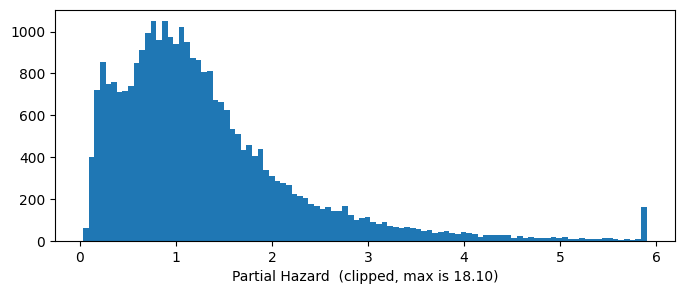

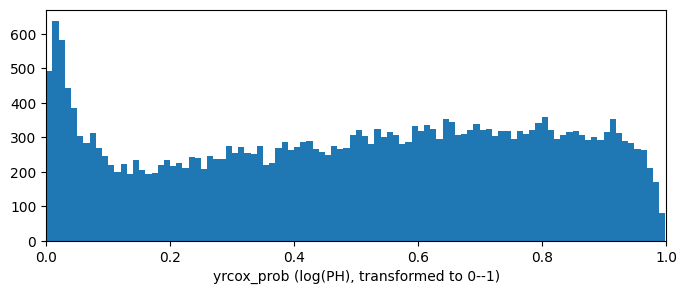

With race as one-hots:
C Score = 0.6929 (std=0.0000, total=0.6929) from:  [0.6929]
Stratified by race_group:
C Score = 0.6930 (std=0.0000, total=0.6930) from:  [0.693]


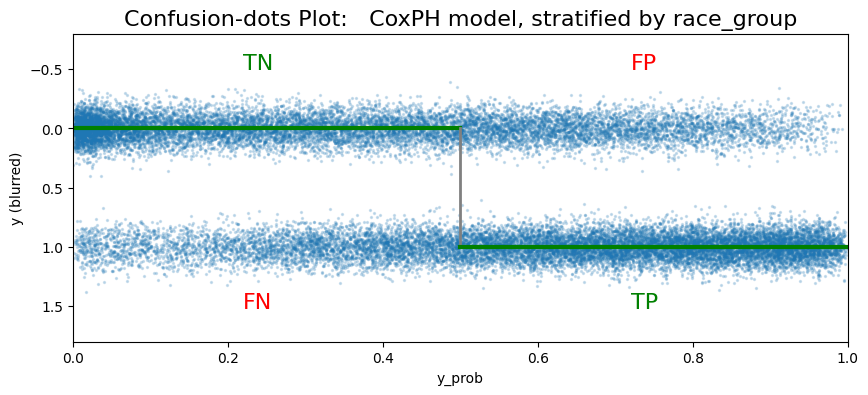

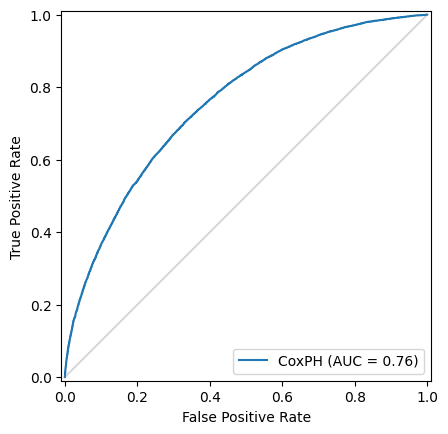

In [108]:
# Make predictions using the partial hazards
# (OK to include extra columns in the X)
cph_hazards = cph.predict_partial_hazard(X)
cphr_hazards = cphr.predict_partial_hazard(Xyr_cox)
  
# Re-value the hazards, take log() then 0 to 1 range
ycox_prob = values_logisticized(np.log(cph_hazards))
yrcox_prob = values_logisticized(np.log(cphr_hazards))

# CoxPH predictions for the test data
test_hazards = cph.predict_partial_hazard(Xtest)
testr_hazards = cphr.predict_partial_hazard(Xrtest)
testycox_prob = values_logisticized(np.log(test_hazards))
testyrcox_prob = values_logisticized(np.log(testr_hazards))

# The Partial Hazards
plt.figure(figsize=(8,3))
plt.hist(np.clip(cphr_hazards,-1.0,5.9),bins=100,log=False)
plt.xlabel("Partial Hazard  (clipped, max is {:.2f})".format(np.max(cphr_hazards)))
##plt.xlim(0.0,6.0)
plt.savefig("Cox_partial_hazards.png")
plt.show()

#The transformed values used as "probs"
plt.figure(figsize=(8,3))
plt.hist(yrcox_prob,bins=100,log=False)
plt.xlabel("yrcox_prob (log(PH), transformed to 0--1)")
plt.xlim(0.0,1.0)
plt.savefig("Cox_prob_from_PHs.png")
plt.show()

# Evaluate the train c-index
print("With race as one-hots:")
print_score(ycox_prob)
print("Stratified by race_group:")
print_score(yrcox_prob)

# Show confusion dots using efs as the y
y = train['efs']
y_prob = yrcox_prob
confusion_dots_roc(train['efs'], yrcox_prob, "  CoxPH model, stratified by race_group",
                         "CoxPH", plots_prefix="Cox_model")


In [116]:
# All features
FEATURES = categ_cols + numer_cols
#Keep the continuous ages and drop their decile, categorical versions
FEATURES.remove('donor_age_dec')
FEATURES.remove('age_at_hct_dec') 

# An experiment  ******************
FEATURES.remove('rituximab')

print("Using {} features:\n".format(len(FEATURES)),FEATURES,"\n")

# Can loop over some (hyper-)parameter's values to do rough tuning
param_vals = [0] #np.linspace(7.0, 8.2, num=13, endpoint=True)
oof_score_vals = []
itf_score_vals = []
for this_param in param_vals:
 # Set the threshold for y_time
    time_threshold = 7.20
    train['y_time'] = 1.0*(train['efs_time'] < time_threshold)
    target_col = "y_time"
    
    FOLDS = 5
    kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    itf_xgb = np.zeros(len(train))  # the "in the fold" values
    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))  # test predictions
    ave_iterations = 0
    print("\n"+"#"*25)
    # Do CV stratified by race_group
    for i, (train_index, valid_index) in enumerate(
                                    kf.split(train, train['efs'])):  # was race_group
        print("\n"+"#"*25)
    # Do CV stratified by race_group
    for i, (train_index, valid_index) in enumerate(
                                    kf.split(train, train['efs'])):  # was race_group
        print(f"### Fold {i+1}")
        # The values for this fold
        x_train = train.loc[train_index,FEATURES].copy()
        y_train = train.loc[train_index,target_col]
        x_valid = train.loc[valid_index,FEATURES].copy()
        y_valid = train.loc[valid_index,target_col]
        x_test = test[FEATURES].copy()

        model_xgb = XGBClassifier(objective='binary:logistic',
            eval_metric="auc",
            random_state=9,
            max_depth=5,  
            colsample_bylevel=0.54,
            subsample=0.80, 
            n_estimators=1000, 
            learning_rate=0.03,
            min_child_weight=35,
            scale_pos_weight=1,
            early_stopping_rounds=15,
            enable_categorical=True,
            max_cat_threshold=10, # max number of categories considered when partitioned:
            max_cat_to_onehot=4,  # ge this: partition into children nodes, else onehots
            gamma=1.5,
            device="cpu"
        )
        model_xgb.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],  
            verbose=None
        )        
        ave_iterations += model_xgb.best_iteration
        # save itf
        itf_xgb[train_index] += model_xgb.predict_proba(x_train)[:,1]
        # INFER OOF
        oof_xgb[valid_index] = model_xgb.predict_proba(x_valid)[:,1]
        # INFER TEST
        pred_xgb += model_xgb.predict_proba(x_test)[:,1]
    ##print("#"*25)
    # oof_xgb doesn't need averaging
    # compute the average in-the-fold preds
    itf_xgb /= (FOLDS - 1)
    # COMPUTE AVERAGE TEST PREDS
    pred_xgb /= FOLDS
    if len(param_vals) > 1:
        print("   The parameter = {:.4f}".format(this_param),
                 "   Average iterations used = {:.0f}".format(ave_iterations/FOLDS))
    else:
        print("   Average iterations used = {:.0f}".format(ave_iterations/FOLDS))
    print("In-the-fold score:")
    cscore, carray = print_score(itf_xgb, output=True)
    itf_score_vals.append(cscore)
    print("Out-of-fold score:")
    cscore, carray = print_score(oof_xgb, output=True)
    oof_score_vals.append(cscore)
        

Using 56 features:
 ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10'] 


#########################

#########################


In [117]:

if len(param_vals) > 1:
    plt.figure(figsize=(5,4))
    plt.scatter(param_vals,oof_score_vals,c='blue')
    plt.scatter(param_vals,itf_score_vals,c='orange')
    plt.savefig("XGB_param_scan.png")
    plt.show()

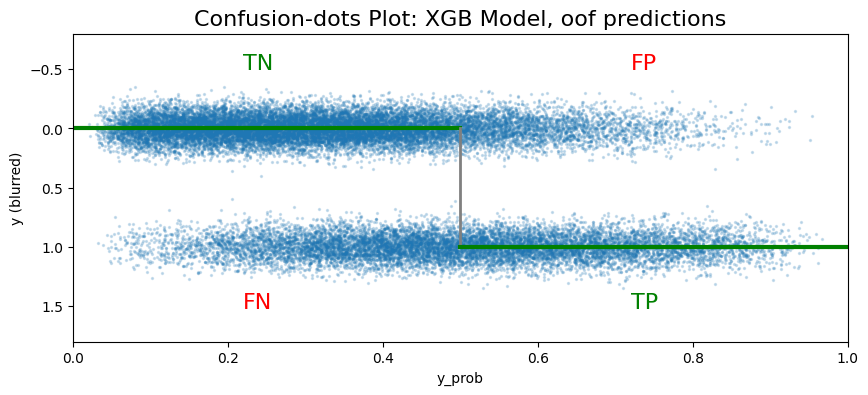

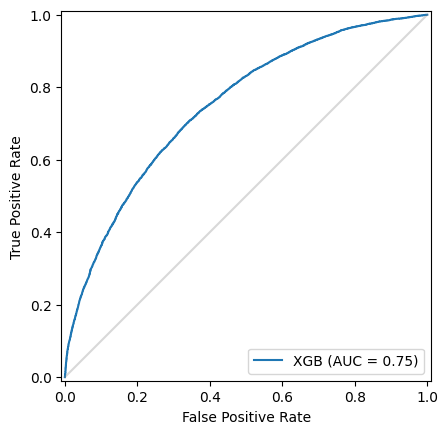

In [118]:
# Look at the Confusion Dots for the oof (or itf) predictions
confusion_dots_roc(train[target_col], oof_xgb, "XGB Model, oof predictions" ,
                 "XGB", plots_prefix="XGB_model_oof")

In [120]:
yxgb_prob = np.zeros(len(train))
testyxgb_prob = np.zeros(len(test))
loop_vals = [-0.10, -0.05, 0.0, 0.05, 0.10]
for iloop, this_val in enumerate(loop_vals):
    if len(loop_vals) > 1: print("Doing",iloop+1,"of",len(loop_vals)," ...")
    model_xgb = XGBClassifier(objective='binary:logistic',
        eval_metric="auc",
        random_state=9,
        max_depth=5,  
        colsample_bylevel=0.54 + this_val, 
        subsample=0.80 - this_val, 
        n_estimators=600, # <-- adjust to ~ ave iterations
        learning_rate=0.03,
        min_child_weight=35,
        scale_pos_weight=1,
        early_stopping_rounds=None, 
        enable_categorical=True,
        max_cat_threshold=10,
        max_cat_to_onehot=4,
        gamma=1.5,
        device="cpu",
    )
    
    model_xgb.fit(train[FEATURES].copy(), train[target_col], verbose=100)
    print(20*" ","R-squared = {:.6f}".format(
            model_xgb.score(train[FEATURES].copy(), train[target_col])))
    yxgb_prob += model_xgb.predict_proba(train[FEATURES])[:,1]
    testyxgb_prob += model_xgb.predict_proba(test[FEATURES])[:,1]

yxgb_prob /= len(loop_vals)
testyxgb_prob /= len(loop_vals)

print("All-training C-score:")
print_score(yxgb_prob)


Doing 1 of 5  ...
                     R-squared = 0.744306
Doing 2 of 5  ...
                     R-squared = 0.744375
Doing 3 of 5  ...
                     R-squared = 0.744722
Doing 4 of 5  ...
                     R-squared = 0.746007
Doing 5 of 5  ...
                     R-squared = 0.745833
All-training C-score:
C Score = 0.7289 (std=0.0000, total=0.7289) from:  [0.7289]


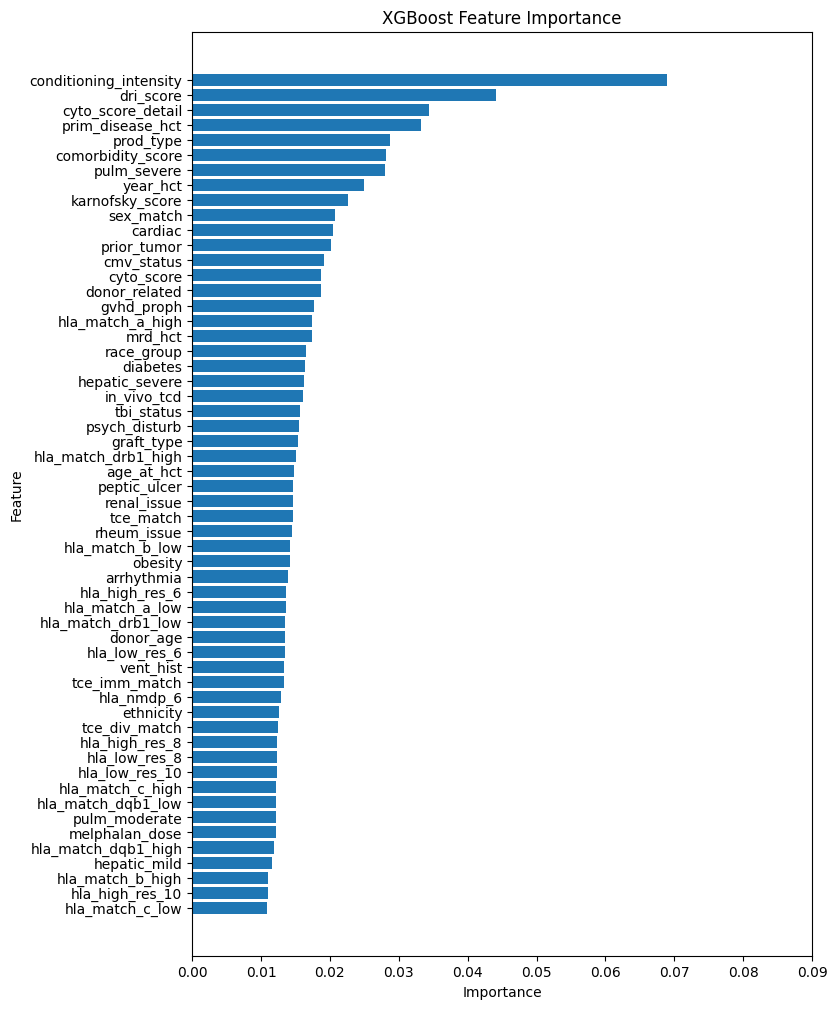

In [121]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(8, 12))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.xlim(0.0,0.09)  
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig("XGB_feature_importances.png")
plt.show()

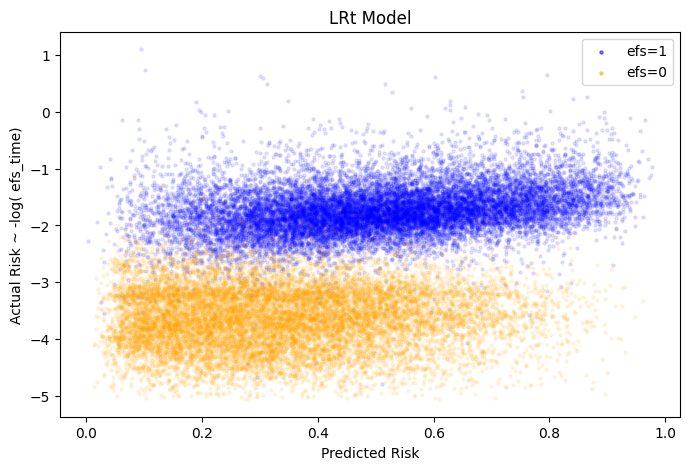

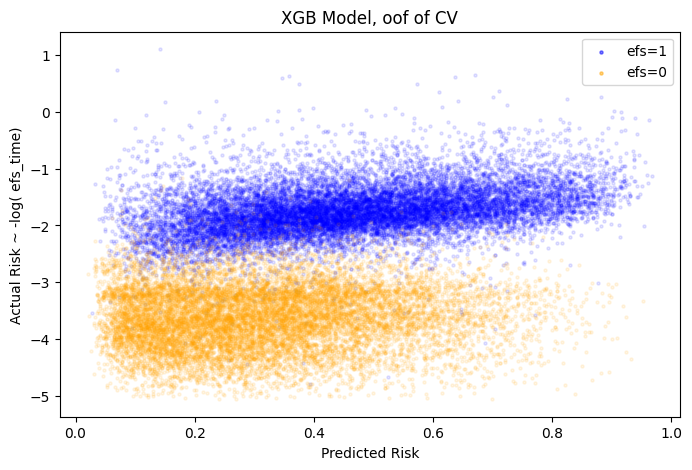

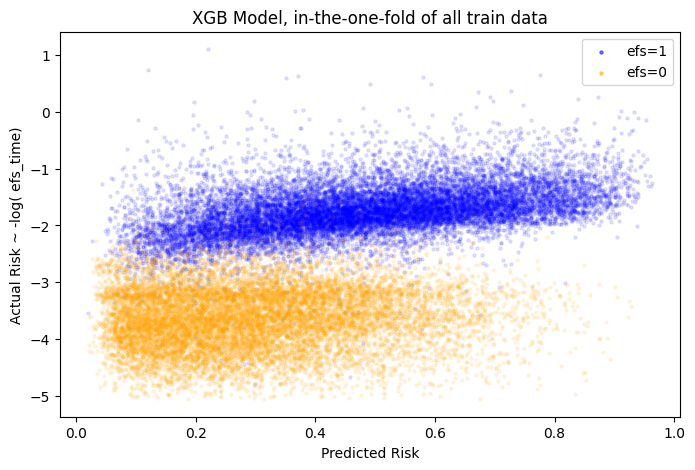

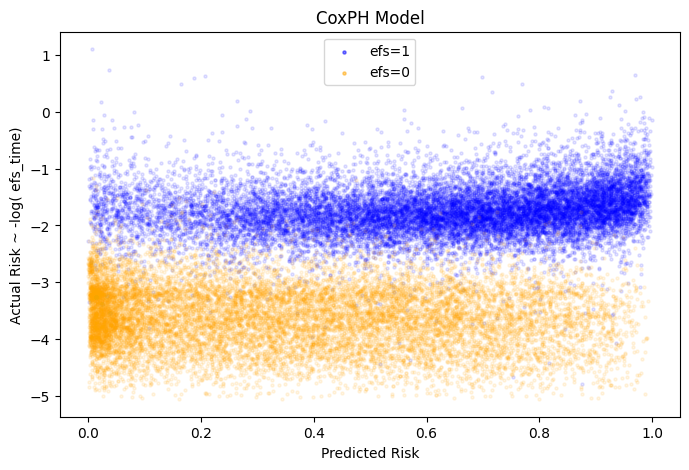

In [122]:
# Show how the approx risk, -log(efs_time), varies with each model's predictions.
efs1_sel = np.where(ye == 1.0)[0]  # it's a tuple
efs0_sel = np.where(ye == 0.0)[0]
efs_risk = -1.0*np.log(train['efs_time'])
risk_label = "Actual Risk ~ -log( efs_time)"

plt.figure(figsize=(8,5))
# For the ledgend:
plt.scatter(yt_prob[efs1_sel[0]],efs_risk[efs1_sel[0]],c='blue',s=5,alpha=0.5,label="efs=1")
plt.scatter(yt_prob[efs0_sel[0]],efs_risk[efs0_sel[0]],c='orange',s=5,alpha=0.5,label="efs=0")
# LR
plt.scatter(yt_prob[efs1_sel],efs_risk[efs1_sel],c='blue',s=5,alpha=0.10)
plt.scatter(yt_prob[efs0_sel],efs_risk[efs0_sel],c='orange',s=5,alpha=0.10)
plt.legend()
plt.ylabel(risk_label); plt.xlabel("Predicted Risk")
plt.title("LRt Model")
plt.show()
plt.figure(figsize=(8,5))
# For the ledgend:
plt.scatter(oof_xgb[efs1_sel[0]],efs_risk[efs1_sel[0]],c='blue',s=5,alpha=0.5,label="efs=1")
plt.scatter(oof_xgb[efs0_sel[0]],efs_risk[efs0_sel[0]],c='orange',s=5,alpha=0.5,label="efs=0")
# XGB  oof_xgb
plt.scatter(oof_xgb[efs1_sel],efs_risk[efs1_sel],c='blue',s=5,alpha=0.10)
plt.scatter(oof_xgb[efs0_sel],efs_risk[efs0_sel],c='orange',s=5,alpha=0.10)
plt.legend()
plt.ylabel(risk_label); plt.xlabel("Predicted Risk")
plt.title("XGB Model, oof of CV")
plt.show()

plt.figure(figsize=(8,5))
# For the ledgend:
plt.scatter(yxgb_prob[efs1_sel[0]],efs_risk[efs1_sel[0]],c='blue',s=5,alpha=0.5,label="efs=1")
plt.scatter(yxgb_prob[efs0_sel[0]],efs_risk[efs0_sel[0]],c='orange',s=5,alpha=0.5,label="efs=0")
# XGB yxgb_prob - all train fit
plt.scatter(yxgb_prob[efs1_sel],efs_risk[efs1_sel],c='blue',s=5,alpha=0.10)
plt.scatter(yxgb_prob[efs0_sel],efs_risk[efs0_sel],c='orange',s=5,alpha=0.10)
plt.legend()
plt.ylabel(risk_label); plt.xlabel("Predicted Risk")
plt.title("XGB Model, in-the-one-fold of all train data") 
plt.show()

plt.figure(figsize=(8,5))
# For the ledgend:
plt.scatter(yrcox_prob[efs1_sel[0]],efs_risk[efs1_sel[0]],c='blue',s=5,alpha=0.5,label="efs=1")
plt.scatter(yrcox_prob[efs0_sel[0]],efs_risk[efs0_sel[0]],c='orange',s=5,alpha=0.5,label="efs=0")
# Cox
plt.scatter(yrcox_prob[efs1_sel],efs_risk[efs1_sel],c='blue',s=5,alpha=0.10)
plt.scatter(yrcox_prob[efs0_sel],efs_risk[efs0_sel],c='orange',s=5,alpha=0.10)
plt.legend()
plt.ylabel(risk_label); plt.xlabel("Predicted Risk")
plt.title("CoxPH Model") 
plt.show()

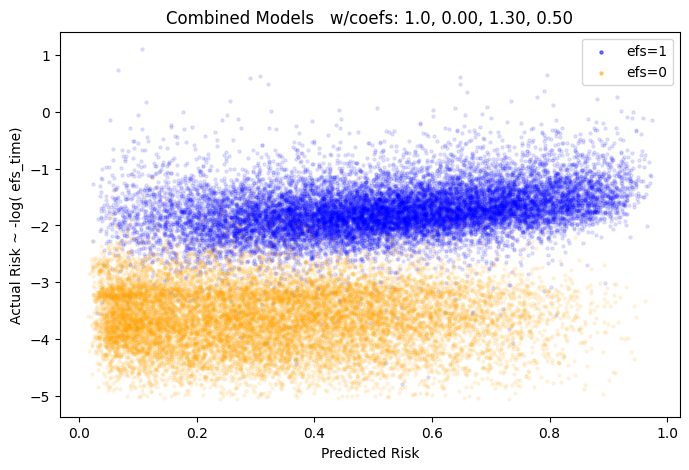

The training score:
C Score = 0.7022 (std=0.0000, total=0.7022) from:  [0.7022]


In [123]:
klrt = 0.0   # LRt
kxgb = 1.3   # XGB oof
k2xgb = 0.50  # XGB fit all
yfinal_prob = ((yrcox_prob + klrt*yt_prob + kxgb*oof_xgb + k2xgb*yxgb_prob)/
                   (1.0 + klrt + kxgb + k2xgb))

plt.figure(figsize=(8,5))
# For the ledgend:
plt.scatter(yfinal_prob[efs1_sel[0]],efs_risk[efs1_sel[0]],c='blue',s=5,alpha=0.5,label="efs=1")
plt.scatter(yfinal_prob[efs0_sel[0]],efs_risk[efs0_sel[0]],c='orange',s=5,alpha=0.5,label="efs=0")
# XGB vs Cox
plt.scatter(yfinal_prob[efs1_sel],efs_risk[efs1_sel],c='blue',s=5,alpha=0.10)
plt.scatter(yfinal_prob[efs0_sel],efs_risk[efs0_sel],c='orange',s=5,alpha=0.10)
plt.legend()
plt.ylabel(risk_label); plt.xlabel("Predicted Risk")
plt.title("Combined Models   w/coefs: 1.0, {:.2f}, {:.2f}, {:.2f}".format(
                klrt, kxgb, k2xgb));
plt.savefig("Combined_actual_vs_predicted.png")
plt.show()

# The selected one's train C score
print("The training score:")
print_score(yfinal_prob)

# v78: LB 0.681+ Removed CoxPH penalty, added heat map of LR coef.s by race for high std ones.
#                C Score = 0.6890 (std=0.0081, total=0.6971) from:  [0.7035 0.7091 0.6882 0.7011 0.6941 0.6866]

In [124]:
testyfinal_prob = ((testyrcox_prob + klrt*testyt_prob + kxgb*pred_xgb +
                    k2xgb*testyxgb_prob) / (1.0 + klrt + kxgb + k2xgb))

In [125]:
# Output the prediction selected
test['prediction'] = testyfinal_prob

# Submission format
# ID,prediction
# 28800,0.5
# 28801,0.5
# 28802,0.5
test[['ID','prediction']].round(6).to_csv("submission.csv", index=False)

In [16]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset
from warnings import filterwarnings

def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T
def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers

def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers
def init_dl(X_cat, X_num, df, training=False):
     ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
     bs = 2048
     dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
     return dl_train


def get_feature_types(train):
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical 

def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    # sex_match = df.sex_match.astype(str)
    # sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    # df['sex_match_bool'] = sex_match
    # df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    # df['big_age'] = df.age_at_hct > 16
    # df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    # df['strange_age'] = df.age_at_hct == 0.044
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    # df['age_ts'] = df.age_at_hct / df.donor_age
    df['year_hct'] -= 2000
    
    return df

def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv("test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train



In [25]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm
class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        ) 
    
    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)
    

class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        ) 
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x
    def combinations(N):
        ind = torch.arange(N)
        comb = torch.combinations(ind, r=2)
        return comb.cuda()
    class LitNN(pl.LightningModule):
            def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
               super( LitNN, self).__init__()
               self.save_hyperparameters()
        
               self.model = NN(
               continuous_dim=self.hparams.continuous_dim,
               categorical_cardinality=self.hparams.categorical_cardinality,
               embedding_dim=self.hparams.embedding_dim,
               projection_dim=self.hparams.projection_dim,
               hidden_dim=self.hparams.hidden_dim,
               dropout=self.hparams.dropout
        ) 
               self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
               self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )
        
    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb
    def training_step(self, batch, batch_idx):
             
             x_cat, x_cont, y, efs = batch
             y_hat, emb = self(x_cat, x_cont)
             aux_pred = self.aux_cls(emb).squeeze(1)
             loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
             aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
             aux_mask = efs == 1
             aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
             self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
             self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
             self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
             return loss + aux_loss * self.hparams.aux_weight
    
    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss
    def get_race_losses(self, efs, x_cat, y, y_hat):
    
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)
    def calc_loss(self, y, y_hat, efs):
        
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss
    def get_mask(self, comb, efs, y_left, y_right):
          left_outlived = y_left >= y_right
          left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
          mask2 = (left_outlived & left_1_right_0)
          right_outlived = y_right >= y_left
          right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
          mask2 |= (right_outlived & right_1_left_0)
          mask2 = ~mask2
          mask = mask2
          return mask
    def validation_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def on_validation_epoch_end(self):
          cindex, metric = self._calc_cindex()
          self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
          self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
          self.targets.clear()
    def _calc_cindex(self):
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric 
    def _metric(self, efs, races, y, y_hat):
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric      
    def test_step(self, batch, batch_idx):
                x_cat, x_cont, y, efs = batch
                y_hat, emb = self(x_cat, x_cont)
                loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
                self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
                self.log("test_loss", loss)
                return loss 
    def on_test_epoch_end(self) -> None:
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear() 
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        } 
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}        
                            

In [28]:
import json
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold
pl.seed_everything(42)

def main(hparams):
        test, train = load_data()
        test['efs_time'] = 1
        test['efs'] = 1
        oof_nn_pairwise = np.zeros(len(train))
        test_pred = np.zeros(test.shape[0])
        categorical_cols, numerical = get_feature_types(train)
        kf = StratifiedKFold(n_splits=5, shuffle=True, )
        for i, (train_index, test_index) in enumerate(
        kf.split(
            train, train.race_group.astype(str) + (train.age_at_hct == 0.044).astype(str)
        )
        ):
            tt = train.copy()
            train = tt.iloc[train_index]
            val = tt.iloc[test_index]
            X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
            model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
        oof_pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        oof_nn_pairwise[test_index] = oof_pred.detach().cpu().numpy()
        train = tt.iloc[train_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, test)
        pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        test_pred += pred.detach().cpu().numpy()
        
    
        return -test_pred, -oof_nn_pairwise


def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
        model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        log_every_n_steps=6,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    ) 
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()   

Seed set to 42


In [29]:
hparams = None
pairwise_ranking_pred, pairwise_ranking_oof = main(hparams)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN CV =",m)

# Update predictions with classifier mask
pairwise_ranking_oof[oof_xgb == 1] += 0.2
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN with classifier mask -> CV =",m)

pairwise_ranking_pred[pred_efs == 1] += 0.2

Test shape: (3, 59)
Train shape: (28800, 61)


NameError: name 'LitNN' is not defined